# **EXPLORATORY DATA ANALYSIS ON TTC STATIONS**
This is the third part of my TTC Subway Delay project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar
import requests
import json
import io
import geopandas as gpd
from shapely.geometry import shape, Point

In [2]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

Date   Time     Day                Station   Code  Min Delay  \
0      2024-01-01  02:00  Monday       SHEPPARD STATION    MUI          0   
1      2024-01-01  02:00  Monday         DUNDAS STATION   MUIS          0   
2      2024-01-01  02:08  Monday         DUNDAS STATION  MUPAA          4   
3      2024-01-01  02:13  Monday     KENNEDY BD STATION  PUTDN         10   
4      2024-01-01  02:22  Monday          BLOOR STATION  MUPAA          4   
...           ...    ...     ...                    ...    ...        ...   
214456 2017-04-30  19:50  Sunday  BLOOR DANFORTH SUBWAY    MUO          0   
214457 2017-04-30  20:25  Sunday         WARDEN STATION   SUDP          4   
214458 2017-04-30  20:29  Sunday          KEELE STATION  SUROB          0   
214459 2017-04-30  22:00  Sunday  YONGE UNIVERSITY LINE    MUO          0   
214460 2017-04-30  22:13  Sunday  BLOOR DANFORTH SUBWAY   MUGD          0   

        Min Gap Bound   Line  Vehicle   station_clean  \
0             0     N     YU     5491  Sheppard-Yonge   
1             0     N     YU        0          Dundas   
2            10     N     YU     6051          Dundas   
3            16     E     BD     5284         Kennedy   
4            10     N     YU     5986     Bloor-Yonge   
...         ...   ...    ...      ...             ...   
214456        0   NaN     BD        0     Bloor-Yonge   
214457        8     W     BD     5107          Warden   
214458        0   NaN     BD        0           Keele   
214459        0   NaN  YU/BD        0     Bloor-Yonge   
214460        0   NaN     BD        0     Bloor-Yonge   

                     line_clean            datetime    time_period  \
0          Lines 1 and 4 Shared 2024-01-01 02:00:00  early_morning   
1       Line 1 Yonge-University 2024-01-01 02:00:00  early_morning   
2       Line 1 Yonge-University 2024-01-01 02:08:00  early_morning   
3          Lines 2 and 3 Shared 2024-01-01 02:13:00  early_morning   
4          Lines 1 and 2 Shared 2024-01-01 02:22:00  early_morning   
...                         ...                 ...            ...   
214456     Lines 1 and 2 Shared 2017-04-30 19:50:00        evening   
214457    Line 2 Bloor-Danforth 2017-04-30 20:25:00        evening   
214458    Line 2 Bloor-Danforth 2017-04-30 20:29:00        evening   
214459     Lines 1 and 2 Shared 2017-04-30 22:00:00        evening   
214460     Lines 1 and 2 Shared 2017-04-30 22:13:00        evening   

                                              delay_cause     delay_category  
0        Injured or ill Customer (On Train) - Transported  Passenger Related  
1       Injured or ill Customer (In Station) - Transpo...  Passenger Related  
2       Passenger Assistance Alarm Activated - No Trou...  Passenger Related  
3                  Debris At Track Level - Uncontrollable   Fortuitous Event  
4       Passenger Assistance Alarm Activated - No Trou...  Passenger Related  
...                                                   ...                ...  
214456                                Miscellaneous Other          Undefined  
214457                                  Disorderly Patron  Passenger Related  
214458                                            Robbery  Passenger Related  
214459                                Miscellaneous Other          Undefined  
214460                       Miscellaneous General Delays          Undefined  

[214461 rows x 16 columns]

# Map Data Extraction and Cleaning

Here, we'll conduct EDA on the stations and check for any patterns or trends. We'll be importing map data from an arcgis database accessible through a url, so we can plot our data in a map that will look like the TTC subway. We can also do an EDA using the typical charts such as bar or line, but I want to make things visually interesting for the spatial data we have for this part of our EDA.

In [3]:
url = "https://gis.toronto.ca/arcgis/rest/services/cot_geospatial7/FeatureServer/8/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses
geojson_data = json.loads(response.text)

# Convert the GeoJSON data to a GeoDataFrame
ttc_map = gpd.GeoDataFrame.from_features(geojson_data["features"])
ttc_map

geometry  ADDRESS_POINT_ID ADDRESS_NUMBER  \
0   POINT (-79.39835 43.70534)          11272589           2190   
1   POINT (-79.39712 43.69785)           7273830           1900   
2   POINT (-79.39298 43.68811)          14076438             15   
3   POINT (-79.39079 43.68229)           8681089             16   
4   POINT (-79.38875 43.67694)            788874              7   
..                         ...               ...            ...   
68  POINT (-79.41309 43.76901)          14076455           5152   
69   POINT (-79.41236 43.7617)          13967653             20   
70   POINT (-79.40636 43.7449)          12036646           4025   
71  POINT (-79.40193 43.72535)           7762894           3101   
72  POINT (-79.46265 43.74993)          10561028           1035   

   LINEAR_NAME_FULL         ADDRESS_FULL POSTAL_CODE    MUNICIPALITY     CITY  \
0          Yonge St        2190 Yonge St     M4S 2B8  former Toronto  Toronto   
1          Yonge St        1900 Yonge St     M4S 1Z2  former Toronto  Toronto   
2    St Clair Ave E    15 St Clair Ave E     M4T 1L8  former Toronto  Toronto   
3   Shaftesbury Ave   16 Shaftesbury Ave        None  former Toronto  Toronto   
4       Crescent Rd        7 Crescent Rd        None  former Toronto  Toronto   
..              ...                  ...         ...             ...      ...   
68         Yonge St        5152 Yonge St        None      North York  Toronto   
69   Sheppard Ave W    20 Sheppard Ave W     M2N 7H9      North York  Toronto   
70         Yonge St        4025 Yonge St     M2P 2E3      North York  Toronto   
71         Yonge St        3101 Yonge St        None  former Toronto  Toronto   
72   Sheppard Ave W  1035 Sheppard Ave W        None      North York  Toronto   

                   PLACE_NAME  GENERAL_USE_CODE  ...  PT_KISS_RIDE  \
0                        None            115001  ...            No   
1                        None            115001  ...            No   
2                        None            115001  ...            No   
3                        None            115001  ...            No   
4                        None            115001  ...            No   
..                        ...               ...  ...           ...   
68                       None            115001  ...            No   
69                       None            115001  ...            No   
70                       None            115001  ...            No   
71  George Milbrandt Parkette            115001  ...            No   
72      Sheppard West Station            115001  ...           Yes   

                                         PT_ESCALATOR PT_ELEVATOR  \
0   Train Platform to Mezzanine, Bus Platform and ...         Yes   
1   Train Platform to Mezzanine, Bus Platform and ...         Yes   
2   Train Platform to Mezzanine, Streetcar Platfor...         Yes   
3                                                  No          No   
4                                                  No          No   
..                                                ...         ...   
68                        Train Platform to Mezzanine          No   
69       Train Platform to Mezzanine and Bus Platform         Yes   
70          Train Platform to Bus Platform and Street         Yes   
71  Train Platform to Mezzanine, Bus Platform and ...          No   
72  Train Platform to Mezzanine, Bus Platform and ...         Yes   

      PT_TRANSF_REQ PT_PUB_WASH        PT_PHONE  PT_OTHER_TRAN  \
0   97,A,B,C,D Only         Yes  (416) 393-4636           None   
1                No          No  (416) 393-4636           None   
2          97B Only          No  (416) 393-4636           None   
3               Yes          No  (416) 393-4636           None   
4          97B Only          No  (416) 393-4636           None   
..              ...         ...             ...            ...   
68      97,B,C Only          No  (416) 393-4636           None   
69      97,B,C Only         Yes  (416) 393-463

Looking at the above extracted geographic data set from arcgis, we can see two (2) concerns:
1. There's no explicit column for the station name. We can, however, extract this from the 'PT_WEBSITE' column; and
2. Two (2) stations are missing from the data set: Vaughan Metropolitan Centre and Highway 407. We'll try to append these two to the data set above. The important features we need are 'LONGITUDE', 'LATITUDE', and the station name.

Let's work on extracting the station name first.

In [4]:
ttc_map['station_clean'] = ttc_map['PT_WEBSITE'].str.extract(r'http://www.ttc.ca/Subway/Stations/([^/]+)')
ttc_map['station_clean'] = ttc_map['station_clean'].str.replace('_', ' ')
ttc_map

geometry  ADDRESS_POINT_ID ADDRESS_NUMBER  \
0   POINT (-79.39835 43.70534)          11272589           2190   
1   POINT (-79.39712 43.69785)           7273830           1900   
2   POINT (-79.39298 43.68811)          14076438             15   
3   POINT (-79.39079 43.68229)           8681089             16   
4   POINT (-79.38875 43.67694)            788874              7   
..                         ...               ...            ...   
68  POINT (-79.41309 43.76901)          14076455           5152   
69   POINT (-79.41236 43.7617)          13967653             20   
70   POINT (-79.40636 43.7449)          12036646           4025   
71  POINT (-79.40193 43.72535)           7762894           3101   
72  POINT (-79.46265 43.74993)          10561028           1035   

   LINEAR_NAME_FULL         ADDRESS_FULL POSTAL_CODE    MUNICIPALITY     CITY  \
0          Yonge St        2190 Yonge St     M4S 2B8  former Toronto  Toronto   
1          Yonge St        1900 Yonge St     M4S 1Z2  former Toronto  Toronto   
2    St Clair Ave E    15 St Clair Ave E     M4T 1L8  former Toronto  Toronto   
3   Shaftesbury Ave   16 Shaftesbury Ave        None  former Toronto  Toronto   
4       Crescent Rd        7 Crescent Rd        None  former Toronto  Toronto   
..              ...                  ...         ...             ...      ...   
68         Yonge St        5152 Yonge St        None      North York  Toronto   
69   Sheppard Ave W    20 Sheppard Ave W     M2N 7H9      North York  Toronto   
70         Yonge St        4025 Yonge St     M2P 2E3      North York  Toronto   
71         Yonge St        3101 Yonge St        None  former Toronto  Toronto   
72   Sheppard Ave W  1035 Sheppard Ave W        None      North York  Toronto   

                   PLACE_NAME  GENERAL_USE_CODE  ...  \
0                        None            115001  ...   
1                        None            115001  ...   
2                        None            115001  ...   
3                        None            115001  ...   
4                        None            115001  ...   
..                        ...               ...  ...   
68                       None            115001  ...   
69                       None            115001  ...   
70                       None            115001  ...   
71  George Milbrandt Parkette            115001  ...   
72      Sheppard West Station            115001  ...   

                                         PT_ESCALATOR  PT_ELEVATOR  \
0   Train Platform to Mezzanine, Bus Platform and ...          Yes   
1   Train Platform to Mezzanine, Bus Platform and ...          Yes   
2   Train Platform to Mezzanine, Streetcar Platfor...          Yes   
3                                                  No           No   
4                                                  No           No   
..                                                ...          ...   
68                        Train Platform to Mezzanine           No   
69       Train Platform to Mezzanine and Bus Platform          Yes   
70          Train Platform to Bus Platform and Street          Yes   
71  Train Platform to Mezzanine, Bus Platform and ...           No   
72  Train Platform to Mezzanine, Bus Platform and ...          Yes   

      PT_TRANSF_REQ PT_PUB_WASH        PT_PHONE  PT_OTHER_TRAN  \
0   97,A,B,C,D Only         Yes  (416) 393-4636           None   
1                No          No  (416) 393-4636           None   
2          97B Only          No  (416) 393-4636           None   
3               Yes          No  (416) 393-4636           None   
4          97B Only          No  (416) 393-4636           None   
..              ...         ...             ...            ...   
68      97,B,C Only          No  (416) 393-4636           None   
69      97,B,C Only         Yes  (416) 393-4636           None   
70      97,B,C Only          No  (416) 393-4636  GO York Mills   
71  97,A,B,C,D Only          No  (416) 393-4636           None   
72  

Now that that's done, let's work on adding the rows for the two (2) missing stations.

In [5]:
new_rows = [{'station_clean': 'Vaughan Metropolitan Centre',
             'LONGITUDE': '-79.5275',
             'LATITUDE': '43.794167'},
             {'station_clean': 'Highway 407',
             'LONGITUDE': '-79.523056',
             'LATITUDE': '43.783333'}]

for row in new_rows:
    for col in ttc_map.columns:
        row.setdefault(col, np.nan)

# Append new rows
ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)
ttc_map

/var/folders/0w/36fvl5tn3b71hvbn68mbwpkm0000gn/T/ipykernel_2741/3714397909.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)


geometry  ADDRESS_POINT_ID ADDRESS_NUMBER  \
0   POINT (-79.39835 43.70534)        11272589.0           2190   
1   POINT (-79.39712 43.69785)         7273830.0           1900   
2   POINT (-79.39298 43.68811)        14076438.0             15   
3   POINT (-79.39079 43.68229)         8681089.0             16   
4   POINT (-79.38875 43.67694)          788874.0              7   
..                         ...               ...            ...   
70   POINT (-79.40636 43.7449)        12036646.0           4025   
71  POINT (-79.40193 43.72535)         7762894.0           3101   
72  POINT (-79.46265 43.74993)        10561028.0           1035   
73                        None               NaN            NaN   
74                        None               NaN            NaN   

   LINEAR_NAME_FULL         ADDRESS_FULL POSTAL_CODE    MUNICIPALITY     CITY  \
0          Yonge St        2190 Yonge St     M4S 2B8  former Toronto  Toronto   
1          Yonge St        1900 Yonge St     M4S 1Z2  former Toronto  Toronto   
2    St Clair Ave E    15 St Clair Ave E     M4T 1L8  former Toronto  Toronto   
3   Shaftesbury Ave   16 Shaftesbury Ave        None  former Toronto  Toronto   
4       Crescent Rd        7 Crescent Rd        None  former Toronto  Toronto   
..              ...                  ...         ...             ...      ...   
70         Yonge St        4025 Yonge St     M2P 2E3      North York  Toronto   
71         Yonge St        3101 Yonge St        None  former Toronto  Toronto   
72   Sheppard Ave W  1035 Sheppard Ave W        None      North York  Toronto   
73              NaN                  NaN         NaN             NaN      NaN   
74              NaN                  NaN         NaN             NaN      NaN   

                   PLACE_NAME  GENERAL_USE_CODE  ...  \
0                        None          115001.0  ...   
1                        None          115001.0  ...   
2                        None          115001.0  ...   
3                        None          115001.0  ...   
4                        None          115001.0  ...   
..                        ...               ...  ...   
70                       None          115001.0  ...   
71  George Milbrandt Parkette          115001.0  ...   
72      Sheppard West Station          115001.0  ...   
73                        NaN               NaN  ...   
74                        NaN               NaN  ...   

                                         PT_ESCALATOR  PT_ELEVATOR  \
0   Train Platform to Mezzanine, Bus Platform and ...          Yes   
1   Train Platform to Mezzanine, Bus Platform and ...          Yes   
2   Train Platform to Mezzanine, Streetcar Platfor...          Yes   
3                                                  No           No   
4                                                  No           No   
..                                                ...          ...   
70          Train Platform to Bus Platform and Street          Yes   
71  Train Platform to Mezzanine, Bus Platform and ...           No   
72  Train Platform to Mezzanine, Bus Platform and ...          Yes   
73                                                NaN          NaN   
74                                                NaN          NaN   

      PT_TRANSF_REQ PT_PUB_WASH        PT_PHONE  PT_OTHER_TRAN  \
0   97,A,B,C,D Only         Yes  (416) 393-4636           None   
1                No          No  (416) 393-4636           None   
2          97B Only          No  (416) 393-4636           None   
3               Yes          No  (416) 393-4636           None   
4          97B Only          No  (416) 393-4636           None   
..              ...         ...             ...            ...   
70      97,B,C Only          No  (416) 393-4636  GO York Mills   
71  97,A,B,C,D Only          No  (416) 393-4636           None   
72               No         Yes  (416) 393-4636           None   
73              NaN         NaN             NaN            NaN   
74  

Afterwards, we'll have to ensure that the 'geometry' attribute captures the longitude and latitude data, and is in the correct data type, geospatial.

In [6]:
ttc_map['geometry'] = gpd.points_from_xy(ttc_map['LONGITUDE'], ttc_map['LATITUDE'])
ttc_map = gpd.GeoDataFrame(ttc_map, geometry = 'geometry')
ttc_map

geometry  ADDRESS_POINT_ID ADDRESS_NUMBER  \
0   POINT (-79.39836 43.70535)        11272589.0           2190   
1   POINT (-79.39713 43.69786)         7273830.0           1900   
2   POINT (-79.39299 43.68812)        14076438.0             15   
3    POINT (-79.39079 43.6823)         8681089.0             16   
4   POINT (-79.38875 43.67694)          788874.0              7   
..                         ...               ...            ...   
70  POINT (-79.40637 43.74491)        12036646.0           4025   
71  POINT (-79.40193 43.72535)         7762894.0           3101   
72  POINT (-79.46265 43.74993)        10561028.0           1035   
73   POINT (-79.5275 43.79417)               NaN            NaN   
74  POINT (-79.52306 43.78333)               NaN            NaN   

   LINEAR_NAME_FULL         ADDRESS_FULL POSTAL_CODE    MUNICIPALITY     CITY  \
0          Yonge St        2190 Yonge St     M4S 2B8  former Toronto  Toronto   
1          Yonge St        1900 Yonge St     M4S 1Z2  former Toronto  Toronto   
2    St Clair Ave E    15 St Clair Ave E     M4T 1L8  former Toronto  Toronto   
3   Shaftesbury Ave   16 Shaftesbury Ave        None  former Toronto  Toronto   
4       Crescent Rd        7 Crescent Rd        None  former Toronto  Toronto   
..              ...                  ...         ...             ...      ...   
70         Yonge St        4025 Yonge St     M2P 2E3      North York  Toronto   
71         Yonge St        3101 Yonge St        None  former Toronto  Toronto   
72   Sheppard Ave W  1035 Sheppard Ave W        None      North York  Toronto   
73              NaN                  NaN         NaN             NaN      NaN   
74              NaN                  NaN         NaN             NaN      NaN   

                   PLACE_NAME  GENERAL_USE_CODE  ...  \
0                        None          115001.0  ...   
1                        None          115001.0  ...   
2                        None          115001.0  ...   
3                        None          115001.0  ...   
4                        None          115001.0  ...   
..                        ...               ...  ...   
70                       None          115001.0  ...   
71  George Milbrandt Parkette          115001.0  ...   
72      Sheppard West Station          115001.0  ...   
73                        NaN               NaN  ...   
74                        NaN               NaN  ...   

                                         PT_ESCALATOR  PT_ELEVATOR  \
0   Train Platform to Mezzanine, Bus Platform and ...          Yes   
1   Train Platform to Mezzanine, Bus Platform and ...          Yes   
2   Train Platform to Mezzanine, Streetcar Platfor...          Yes   
3                                                  No           No   
4                                                  No           No   
..                                                ...          ...   
70          Train Platform to Bus Platform and Street          Yes   
71  Train Platform to Mezzanine, Bus Platform and ...           No   
72  Train Platform to Mezzanine, Bus Platform and ...          Yes   
73                                                NaN          NaN   
74                                                NaN          NaN   

      PT_TRANSF_REQ PT_PUB_WASH        PT_PHONE  PT_OTHER_TRAN  \
0   97,A,B,C,D Only         Yes  (416) 393-4636           None   
1                No          No  (416) 393-4636           None   
2          97B Only          No  (416) 393-4636           None   
3               Yes          No  (416) 393-4636           None   
4          97B Only          No  (416) 393-4636           None   
..              ...         ...             ...            ...   
70      97,B,C Only          No  (416) 393-4636  GO York Mills   
71  97,A,B,C,D Only          No  (416) 393-4636           None   
72               No         Yes  (416) 393-4636           None   
73              NaN         NaN             NaN            NaN   
74  

In [7]:
ttc_map.dtypes

geometry            geometry
ADDRESS_POINT_ID     float64
ADDRESS_NUMBER        object
LINEAR_NAME_FULL      object
ADDRESS_FULL          object
POSTAL_CODE           object
MUNICIPALITY          object
CITY                  object
PLACE_NAME            object
GENERAL_USE_CODE     float64
CENTRELINE_ID        float64
LO_NUM               float64
LO_NUM_SUF            object
HI_NUM                object
HI_NUM_SUF            object
LINEAR_NAME_ID       float64
X                    float64
Y                    float64
LONGITUDE             object
LATITUDE              object
MAINT_STAGE           object
OBJECTID             float64
PT_ID                float64
PT_TYPE               object
PT_NAME               object
PT_CONN_ROUTE         object
PT_PUB_PARK           object
PT_KISS_RIDE          object
PT_ESCALATOR          object
PT_ELEVATOR           object
PT_TRANSF_REQ         object
PT_PUB_WASH           object
PT_PHONE              object
PT_OTHER_TRAN         object
PT_WEBSITE    

Let's plot it!

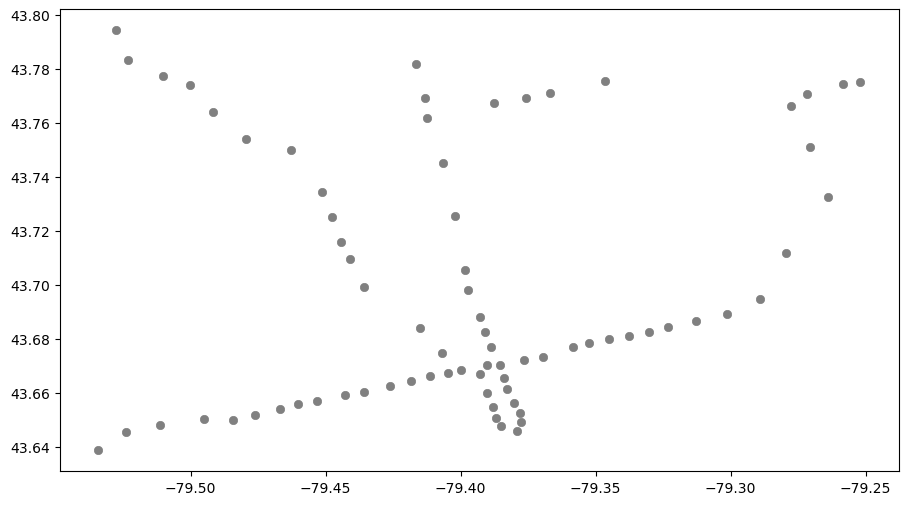

In [8]:
fig, ax = plt.subplots(figsize = (12,6))
ttc_map.plot(ax = ax,
             color = 'gray',
             linewidth = 0.5)
plt.show()

# Functions and Loops

We'll define some functions here that will speed up our EDA.

In [9]:
# create table summaries per delay cause, grouped per station
def station_cause(cause):
    grouped_cause = df_master[df_master['delay_cause'] == cause].groupby(df_master['station_clean']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_cause['average_delay'] = grouped_cause['delay_duration'] / grouped_cause['total_occurrence']
    grouped_cause_top_10 = grouped_cause.sort_values(by = ['delay_duration'], ascending = False).head(10)
    return grouped_cause_top_10

In [10]:
def create_map(cause, 
               title = None,
               color = None):
    # create table summary
    grouped_cause = df_master[df_master['delay_cause'] == cause].groupby(df_master['station_clean']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    # create map based on map data
    fig, ax = plt.subplots(figsize = (12,6))
    ttc_map.plot(ax = ax,
                 color = 'white',
                 linewidth = 0.1)
    # merge grouped table and map data
    merged_data = ttc_map.merge(grouped_cause, left_on = 'station_clean', right_on = 'station_clean', how = 'left')
    # create map based on merged data
    merged_data.plot(ax = ax, 
                    column = 'delay_duration', 
                    cmap = color, 
                    legend = True, 
                    markersize = merged_data['delay_duration'] / 10,
                    legend_kwds = {'label': "Total Delay Duration (Minutes)",
                                   'orientation': "vertical"})
    # Annotate the top 10 stations
    top_10_stations = merged_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
    for index, row in top_10_stations.iterrows():
        ax.annotate(row['station_clean'], 
                    (row['geometry'].x, row['geometry'].y),
                    xytext = (row['geometry'].x + 0.005, row['geometry'].y + 0.0),
                    fontsize = 8, 
                    color = 'black')
    # Add labels and title
    plt.title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

In [ ]:
# group per station then per delay cause then per month
def grouped_station(station):
    grouped_data = df_master[df_master['station_clean'] == station].groupby([
        df_master['delay_cause'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()]).agg(
            total_occurrence = ('Min Delay', 'count'),
            delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_data['average_duration'] = grouped_data['delay_duration'] / grouped_data['total_occurrence']
    return grouped_data

In [12]:
# create linear regression table (station)
def linear_regression_table(station):
    grouped_cause = grouped_station(station)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_cause['datetime_numeric'] = grouped_cause['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    for cause in grouped_cause['delay_cause'].unique():
        subset = grouped_cause[grouped_cause['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
    
    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)
    return results_10

In [13]:
# plot linear regression (station)
def linear_regression_plot(station):
    grouped_cause = grouped_station(station)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_cause['datetime_numeric'] = grouped_cause['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    plt.figure(figsize = (15,8))
    for cause in grouped_cause['delay_cause'].unique():
        subset = grouped_cause[grouped_cause['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
     
        # plot the regression line per delay cause
        plt.plot(subset['datetime_numeric'], 
            predicted_y, 
            label = f'{cause} - Regression Line', 
            linestyle = '--')

    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)

    # annotate the top 10 delay causes in terms of slope (only label causes which are strongly statistically significant)
    for i, row in results_10.iterrows():
        subset = grouped_cause[grouped_cause['delay_cause'] == row['delay_cause']]
        max_x = subset['datetime_numeric'].max()
        max_y = row['slope'] * max_x + row['intercept']

        plt.annotate(f"{row['delay_cause']}",
            xy = (max_x, max_y), 
            xytext = (max_x + 10000000, max_y + 0),
            arrowprops = dict(arrowstyle = "->", color = 'black'),
            fontsize = 6)

    plt.xlabel('Date (Numeric)')
    plt.ylabel('Delay Duration (in Minutes)')
    plt.title(f'Linear Regression of Duration of Delay Causes in {station} Station')
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.show()

In [14]:
# create bar chart (station)
def create_bar_chart(station):
    grouped_data = df_master[df_master['station_clean'] == station].groupby(['delay_cause']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_data_top_10 = grouped_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
    wrapped_labels = [textwrap.fill(label, width = 20) for label in grouped_data_top_10['delay_cause']]
    # Plot
    plt.figure(figsize=(12, 5))
    plt.bar(wrapped_labels, grouped_data_top_10['delay_duration'])
    plt.title(f'Top 10 Delay Causes in {station} Station')
    plt.xlabel('Delay Causes')
    plt.xticks(rotation = 90, ha = 'center')
    plt.ylabel('Delay Duration (in Minutes)')
    plt.tight_layout()
    plt.show()

In [ ]:
# group per cause then per station then per month
def grouped_cause(cause):
    grouped_data = df_master[df_master['delay_cause'] == cause].groupby([
        df_master['station_clean'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()]).agg(
            total_occurrence = ('Min Delay', 'count'),
            delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_data['average_duration'] = grouped_data['delay_duration'] / grouped_data['total_occurrence']
    return grouped_data    

In [104]:
# create linear regression table (delay cause)
def linear_regression_table_cause(cause):
    grouped_data = grouped_cause(cause)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_data['datetime_numeric'] = grouped_data['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    for station in grouped_data['station_clean'].unique():
        subset = grouped_data[grouped_data['station_clean'] == station]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'station_clean': station,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
    
    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False)
    return results

In [17]:
# plot linear regression (delay cause)
def linear_regression_plot_cause(cause):
    grouped_data = grouped_cause(cause)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_data['datetime_numeric'] = grouped_data['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    plt.figure(figsize = (15,8))
    for station in grouped_data['station_clean'].unique():
        subset = grouped_data[grouped_data['station_clean'] == station]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'station_clean': station,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
        
        # plot the regression line per station
        plt.plot(subset['datetime_numeric'], 
            predicted_y, 
            label = f'{station} - Regression Line', 
            linestyle = '--')
    
    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_15 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(15)
    
    # annotate the top 15 stations in terms of slope (only label causes which are strongly statistically significant)
    for i, row in results_15.iterrows():
        subset = grouped_data[grouped_data['station_clean'] == row['station_clean']]
        max_x = subset['datetime_numeric'].max()
        max_y = row['slope'] * max_x + row['intercept']

        plt.annotate(f"{row['station_clean']}",
            xy = (max_x, max_y), 
            xytext = (max_x + 10000000, max_y + 0),
            arrowprops = dict(arrowstyle = "->", color = 'black'),
            fontsize = 6)

    plt.xlabel('Date (Numeric)')
    plt.ylabel('Delay Duration (in Minutes)')
    plt.title(f'Linear Regression of {cause} in TTC Stations')
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.show()

# Station Delay Duration and Occurrence

We'll create a summary table for delay occurrence and duration per station.

In [18]:
station = df_master.groupby('station_clean').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum')).reset_index()
station

station_clean  total_occurrence  delay_duration
0          Bathurst              2140            4377
1               Bay              1596            4253
2           Bayview               912            3200
3         Bessarion               532            1837
4       Bloor-Yonge             21332           28188
..              ...               ...             ...
70           Wilson              5429           14621
71         Woodbine              2054            5169
72       York Mills              3105            8503
73  York University               477            1274
74         Yorkdale              1892            4743

[75 rows x 3 columns]

Then we'll merge it with the ttc_map data set.

In [19]:
merged_data = ttc_map.merge(station, left_on = 'station_clean', right_on = 'station_clean', how = 'left')

And we plot!

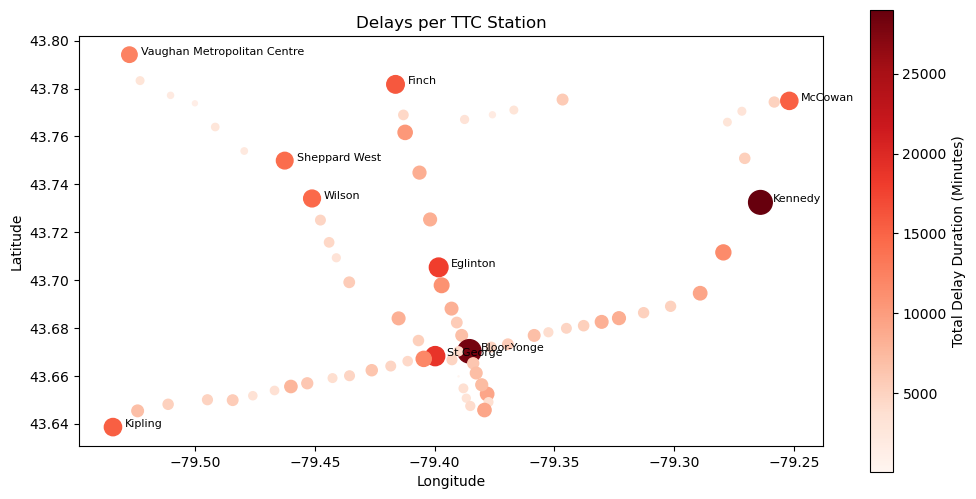

In [20]:
fig, ax = plt.subplots(figsize = (12, 6))
ttc_map.plot(ax = ax, 
             color = 'white', 
             linewidth = 0.5)
merged_data.plot(ax = ax, 
                 column = 'delay_duration', 
                 cmap = 'Reds', 
                 legend = True,
                 markersize = merged_data['delay_duration'] / 100,
                 legend_kwds={'label': "Total Delay Duration (Minutes)",
                              'orientation': "vertical"})
plt.title('Delays per TTC Station')

# Annotate the top 10 stations
top_10_stations = merged_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
for index, row in top_10_stations.iterrows():
    ax.annotate(row['station_clean'], 
                (row['geometry'].x, 
                 row['geometry'].y),
                xytext = (row['geometry'].x + 0.005, row['geometry'].y + 0.0),
                fontsize = 8, 
                color = 'black')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [21]:
top_10_stations

geometry  ADDRESS_POINT_ID ADDRESS_NUMBER  \
66  POINT (-79.26399 43.73249)         6674325.0           2455   
5   POINT (-79.38554 43.67029)         8535683.0             35   
9   POINT (-79.39981 43.66828)         4030665.0            139   
0   POINT (-79.39836 43.70535)        11272589.0           2190   
67  POINT (-79.41638 43.78176)         7171768.0           5714   
34  POINT (-79.53437 43.63864)         8353629.0            950   
61  POINT (-79.25192 43.77487)         6341040.0           1275   
32  POINT (-79.45124 43.73411)         7994198.0            570   
72  POINT (-79.46265 43.74993)        10561028.0           1035   
73   POINT (-79.5275 43.79417)               NaN            NaN   

   LINEAR_NAME_FULL         ADDRESS_FULL POSTAL_CODE    MUNICIPALITY     CITY  \
66   Eglinton Ave E  2455 Eglinton Ave E        None     Scarborough  Toronto   
5        Bloor St E        35 Bloor St E     M4W 1A9  former Toronto  Toronto   
9      St George St     139 St George St     M5R 2L8  former Toronto  Toronto   
0          Yonge St        2190 Yonge St     M4S 2B8  former Toronto  Toronto   
67         Yonge St        5714 Yonge St        None      North York  Toronto   
34      Kipling Ave      950 Kipling Ave        None       Etobicoke  Toronto   
61       McCowan Rd      1275 McCowan Rd        None     Scarborough  Toronto   
32       Wilson Ave       570 Wilson Ave        None      North York  Toronto   
72   Sheppard Ave W  1035 Sheppard Ave W        None      North York  Toronto   
73              NaN                  NaN         NaN             NaN      NaN   

               PLACE_NAME  GENERAL_USE_CODE  ...    PT_TRANSF_REQ  \
66                   None          115001.0  ...               No   
5                    None          115001.0  ...              Yes   
9                    None          115001.0  ...               No   
0                    None          115001.0  ...  97,A,B,C,D Only   
67                   None          115001.0  ...      97,B,C Only   
34                   None          115001.0  ...               No   
61                   None          115001.0  ...              Yes   
32  Wilson Subway Station          115001.0  ...               No   
72  Sheppard West Station          115001.0  ...               No   
73                    NaN               NaN  ...              NaN   

    PT_PUB_WASH        PT_PHONE  \
66          Yes  (416) 393-4636   
5           Yes  (416) 393-4636   
9            No  (416) 393-4636   
0           Yes  (416) 393-4636   
67          Yes  (416) 393-4636   
34          Yes  (416) 393-4636   
61           No  (416) 393-4636   
32          Yes  (416) 393-4636   
72          Yes  (416) 393-4636   
73          NaN             NaN   

                                      PT_OTHER_TRAN  \
66                                             None   
5                                              None   
9                                              None   
0                                              None   
67  GO Finch, York Region Transit, Brampton Transit   
34                                       GO Kipling   
61                                             None   
32                                             None   
72                                             None   
73                                              NaN   

                                           PT_WEBSITE  PT_EXTRA1  PT_EXTRA2  \
66  http://www.ttc.ca/Subway/Stations/Kennedy/stat...       None       None   
5   http://www.ttc.ca/Subway/Stations/Bloor-Yonge/...       None       None   
9   http://www.ttc.ca/Subway/Stations/St_George/st...       None       None   
0   http://www.ttc.ca/Subway/Stations/Eglinton/sta...       None       None   
67  http://www.ttc.ca/Subway/Stations/Finch/statio...       None       None   
34  http://www.ttc.ca/Subway/Stations/Kipling/stat...       None       None   
61  http://www.ttc.ca/Subway/Stations/McCowan/stat...       None       None   
32  http

### Findings: Station Delay Duration and Occurrence

1. The Top 10 stations with the longest total delay duration are: 
    a. Kennedy (29,009 mins), 
    b. Bloor-Yonge (28,188 mins), 
    c. St. George (18,890 mins), 
    d. Eglinton (17,994 mins), 
    e. Finch (15,944 mins), 
    f. Kipling (15,423 mins),
    g. McCowan (15,238 mins),
    h. Wilson (14,621 mins),
    i. Sheppard West (14,287 mins), and
    j. Vaughan Metropolitan Centre (12,356 mins).
2. Five (5) in the top 10 are stations that are the beginning/end of a subway line: Kipling, Kennedy, McCowan, Finch, and Vaughan Metropolitan Centre.
3. Two (2) in the top 10 are interchange stations between Line 1 and Line 2: Bloor-Yonge and St. George.
4. Eglinton Station is the fourth (4th) station with the longest total delay duration. Although it is not an interchange station nor is a beginning/ending station, Eglinton is one of the busiest stations in the TTC because of its location in Midtown Toronto. It also serves as a transit hub for multiple TTC bus routes. Additionally, the TTC has began the construction of another subway line, Line 5, with Eglinton Station serving as an interchange point.
5. Wilson Station is the eighth (8th) station with the longest total delay duration. Like Eglinton, it is not an interchange station nor is a beginning/ending station. It has a large bus terminal providing access to Yorkdale Mall and the Pearson Airport. It is close to Wilson Yard, one of TTC's main subway train storage and maintenance facilities.
6. Sheppard West Station is the ninth (9th) station with the longest total delay duration. Like Eglinton, it is not an interchange station nor is a beginning/ending station. It serves as an important bus hub in North York with connections to TTC bus routes and the York Region Transit. 


# Stations and Delay Causes

## Passenger Related Category

We'll look at the top 5 delay causes under the Passenger Related Category, in terms of delay duration. From our linear regression anaylsis previously, we said that these top 5 exhibited worsening delay durations with very strong statistical significance. 

We'll also conduct linear regression analysis per delay cause per Station.

### Disorderly Patron

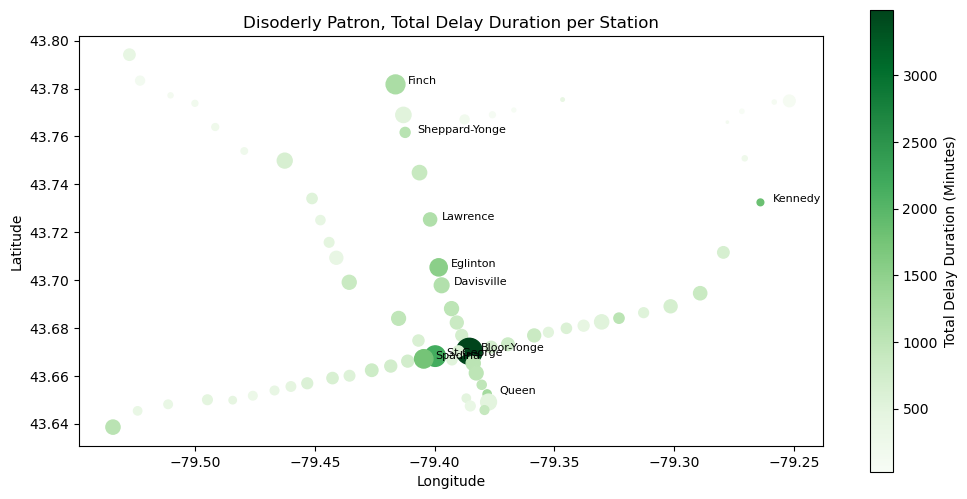

In [22]:
create_map('Disorderly Patron', 
           title = 'Disoderly Patron, Total Delay Duration per Station',
           color = 'Greens')

In [23]:
station_cause('Disorderly Patron')

station_clean  total_occurrence  delay_duration  average_delay
4      Bloor-Yonge              1406            3491       2.482930
61       St George               664            2170       3.268072
31         Kennedy               542            1838       3.391144
57         Spadina               553            1750       3.164557
19        Eglinton               488            1533       3.141393
49           Queen               394            1297       3.291878
22           Finch               495            1205       2.434343
35        Lawrence               239            1151       4.815900
11      Davisville               290            1124       3.875862
55  Sheppard-Yonge               308            1063       3.451299

In terms of total delay duration, Bloor-Yonge Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that all of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [129]:
linear_regression_table_cause('Disorderly Patron')

station_clean         slope   intercept   r-value       p-value  \
4      Bloor-Yonge  1.061293e-07 -138.041245  0.549600  1.835961e-11   
61       St George  8.440905e-08 -113.807332  0.481901  2.189951e-08   
21       Ellesmere  7.501852e-08 -108.484721  0.734286  1.199661e-03   
22           Finch  7.210148e-08 -102.266782  0.447641  1.335896e-06   
57         Spadina  7.070526e-08  -95.470282  0.460025  2.957542e-07   
31         Kennedy  6.930124e-08  -93.156065  0.367296  2.713728e-05   
55  Sheppard-Yonge  5.837570e-08  -81.616861  0.437061  2.809464e-06   
11      Davisville  5.500928e-08  -75.282694  0.405475  3.134272e-05   
33         Kipling  5.271524e-08  -73.361582  0.457382  3.526080e-07   
59        St Clair  5.265675e-08  -72.796273  0.427549  1.254408e-05   
19        Eglinton  4.885679e-08  -63.746683  0.418633  1.445124e-06   
35        Lawrence  4.402600e-08  -57.849106  0.334478  6.707926e-04   
68       Wellesley  3.927010e-08  -52.308813  0.384407  4.002048e-05   
49           Queen  3.751921e-08  -47.507170  0.267993  4.107104e-03   
50        Rosedale  3.742316e-08  -50.981254  0.411724  7.432832e-05   
16          Dundas  3.629296e-08  -48.220682  0.370008  5.936033e-05   
63      Summerhill  3.483746e-08  -45.103702  0.353483  9.049555e-04   
64           Union  3.444134e-08  -45.142683  0.293232  3.223244e-03   
66   Victoria Park  3.387377e-08  -44.397301  0.284176  4.363356e-03   
20   Eglinton West  3.364491e-08  -43.517144  0.314114  2.428019e-03   
9          College  3.344994e-08  -43.410213  0.356374  1.533853e-04   
46       Ossington  2.475608e-08  -30.837435  0.264068  7.321197e-03   
6     Castle Frank  2.338454e-08  -28.663008  0.286884  3.302884e-03   
10         Coxwell  2.114468e-08  -24.094697  0.270479  3.318929e-03   

         std_err pval < 0.05 pval < 0.01  
4   1.437185e-08           Y           Y  
61  1.406934e-08           Y           Y  
21  1.853562e-08           Y           Y  
22  1.405597e-08           Y           Y  
57  1.295315e-08           Y           Y  
31  1.588827e-08           Y           Y  
55  1.177990e-08           Y           Y  
11  1.259166e-08           Y           Y  
33  9.728144e-09           Y           Y  
59  1.142275e-08           Y           Y  
19  9.635149e-09           Y           Y  
35  1.253041e-08           Y           Y  
68  9.160025e-09           Y           Y  
49  1.280222e-08           Y           Y  
50  8.984431e-09           Y           Y  
16  8.688478e-09           Y           Y  
63  1.011942e-08           Y           Y  
64  1.140145e-08           Y           Y  
66  1.160395e-08           Y           Y  
20  1.077904e-08           Y           Y  
9   8.518109e-09           Y           Y  
46  9.042112e-09           Y           Y  
6   7.769825e-09           Y           Y  
10  7.048837e-09           Y           Y

### Unauthorized at Track Level

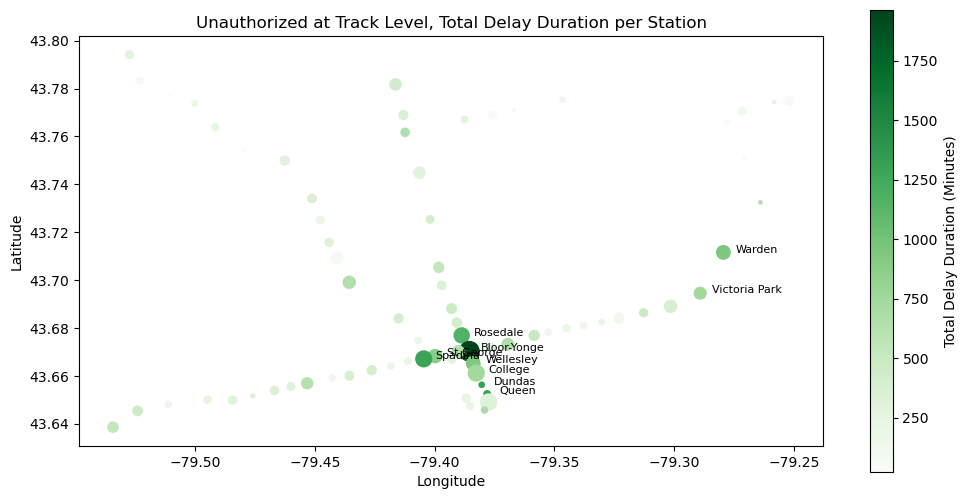

In [100]:
create_map('Unauthorized at Track Level', 
           title = 'Unauthorized at Track Level, Total Delay Duration per Station',
           color = 'Greens')

In [27]:
station_cause('Unauthorized at Track Level')

station_clean  total_occurrence  delay_duration  average_delay
4     Bloor-Yonge               272            1964       7.220588
49          Queen               143            1333       9.321678
16         Dundas               187            1312       7.016043
57        Spadina               145            1288       8.882759
50       Rosedale               118            1165       9.872881
67         Warden               114             940       8.245614
68      Wellesley               117             939       8.025641
61      St George               126             883       7.007937
66  Victoria Park                87             754       8.666667
9         College               103             749       7.271845

In terms of total delay duration, Bloor-Yonge Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that only 2 stations, Bloor-Yonge and Islington, have worsening delay durations with very strong statistical significance.

In [106]:
linear_regression_table_cause('Unauthorized at Track Level')

station_clean         slope  intercept   r-value   p-value       std_err  \
4    Bloor-Yonge  6.808150e-08 -88.636227  0.356075  0.000193  1.760467e-08   
28     Islington  5.351265e-08 -74.687920  0.394122  0.008921  1.948844e-08   

   pval < 0.05 pval < 0.01  
4            Y           Y  
28           Y           Y

### Passenger Other

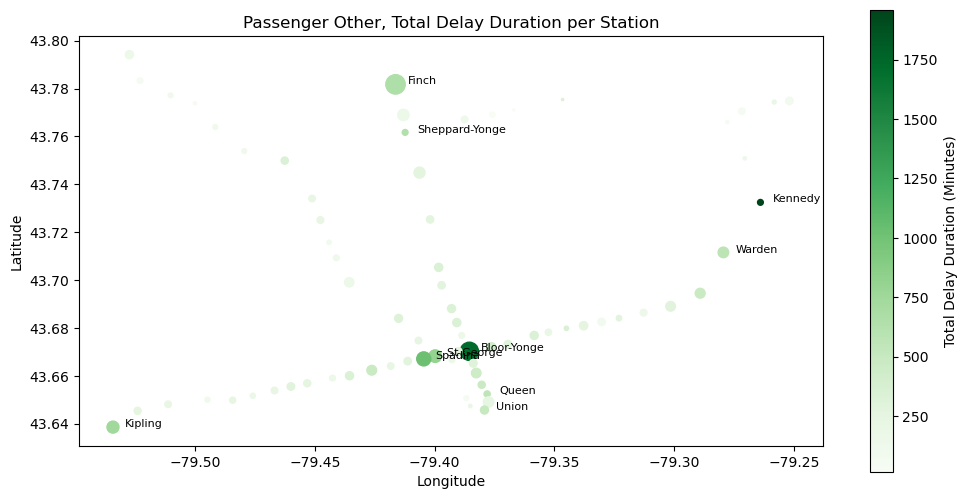

In [28]:
create_map('Passenger Other', 
           title = 'Passenger Other, Total Delay Duration per Station',
           color = 'Greens')

In [29]:
station_cause('Passenger Other')

station_clean  total_occurrence  delay_duration  average_delay
31         Kennedy               331            1959       5.918429
4      Bloor-Yonge               776            1717       2.212629
57         Spadina               336            1020       3.035714
61       St George               297             814       2.740741
33         Kipling               203             745       3.669951
22           Finch               271             660       2.435424
55  Sheppard-Yonge               161             631       3.919255
67          Warden               171             577       3.374269
49           Queen               209             560       2.679426
64           Union               256             504       1.968750

In terms of total delay duration, Kennedy Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that most of the stations in the Top 10 have worsening delay durations with very strong statistical significance, except for St George Station.

In [108]:
linear_regression_table_cause('Passenger Other')

station_clean         slope   intercept   r-value   p-value  \
31         Kennedy  1.132415e-07 -157.919964  0.356057  0.000398   
57         Spadina  7.746277e-08 -110.764113  0.400443  0.000121   
4      Bloor-Yonge  7.209800e-08  -98.179521  0.325611  0.000302   
33         Kipling  5.590425e-08  -79.213721  0.439949  0.000035   
55  Sheppard-Yonge  4.934825e-08  -69.630831  0.361233  0.002883   
22           Finch  4.357735e-08  -61.090822  0.358211  0.000952   
67          Warden  3.929065e-08  -54.817854  0.319076  0.005267   
49           Queen  3.910083e-08  -54.354200  0.320873  0.008111   
64           Union  3.812554e-08  -54.219598  0.298723  0.008762   
16          Dundas  2.348955e-08  -31.633794  0.299504  0.005359   

         std_err pval < 0.05 pval < 0.01  
31  3.081825e-08           Y           Y  
57  1.922609e-08           Y           Y  
4   1.935508e-08           Y           Y  
33  1.275805e-08           Y           Y  
55  1.592326e-08           Y           Y  
22  1.269861e-08           Y           Y  
67  1.365895e-08           Y           Y  
49  1.431538e-08           Y           Y  
64  1.415908e-08           Y           Y  
16  8.213432e-09           Y           Y

### Passenger Assistance Alarm Activated - No Trouble Found

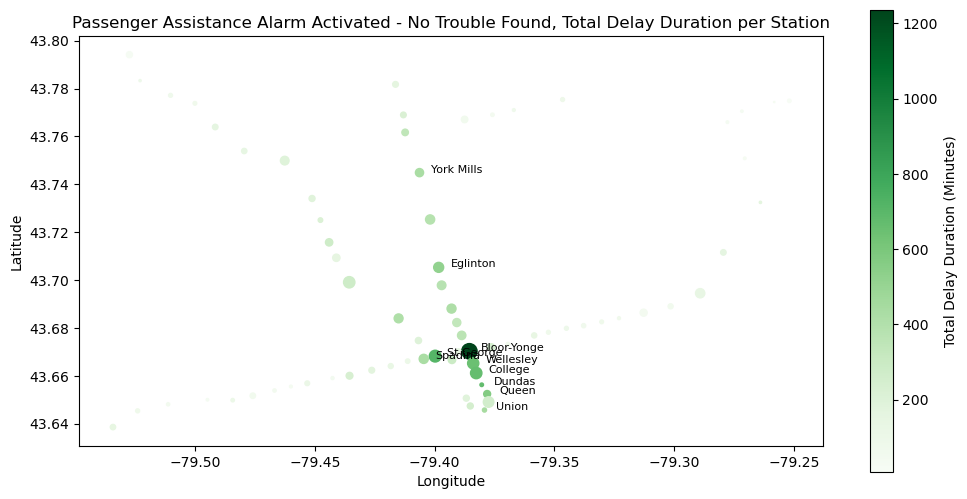

In [30]:
create_map('Passenger Assistance Alarm Activated - No Trouble Found', 
           title = 'Passenger Assistance Alarm Activated - No Trouble Found, Total Delay Duration per Station',
           color = 'Greens')

In [31]:
station_cause('Passenger Assistance Alarm Activated - No Trouble Found')

station_clean  total_occurrence  delay_duration  average_delay
4    Bloor-Yonge              1015            1236       1.217734
61     St George               575             717       1.246957
16        Dundas               449             670       1.492205
9        College               466             667       1.431330
68     Wellesley               529             650       1.228733
49         Queen               465             574       1.234409
19      Eglinton               492             519       1.054878
64         Union               305             448       1.468852
71    York Mills               369             434       1.176152
57       Spadina               335             432       1.289552

In terms of total delay duration, Bloor-Yonge Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that all of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [109]:
linear_regression_table_cause('Passenger Assistance Alarm Activated - No Trouble Found')

station_clean         slope  intercept   r-value       p-value  \
4         Bloor-Yonge  3.125487e-08 -38.989403  0.327910  1.577671e-04   
60      St Clair West  2.702707e-08 -38.339766  0.527965  3.080711e-09   
68          Wellesley  2.689303e-08 -36.661676  0.406402  2.567838e-06   
71         York Mills  2.554290e-08 -35.861734  0.461550  2.670469e-07   
9             College  2.500980e-08 -33.515629  0.382156  1.187681e-05   
61          St George  2.462127e-08 -32.563051  0.393736  5.551983e-06   
16             Dundas  2.354030e-08 -30.872091  0.312402  6.055785e-04   
57            Spadina  2.279193e-08 -31.803480  0.423644  2.153187e-06   
27        Highway 407  2.065893e-08 -31.162327  0.444125  4.093651e-03   
59           St Clair  1.990873e-08 -27.360804  0.430739  1.122651e-06   
73           Yorkdale  1.989109e-08 -28.452839  0.510524  2.342049e-07   
58          St Andrew  1.941521e-08 -27.583410  0.464213  4.601391e-06   
20      Eglinton West  1.888649e-08 -26.988594  0.455720  3.488006e-07   
37      Lawrence West  1.861474e-08 -26.013346  0.460171  3.470403e-06   
23         Finch West  1.854464e-08 -27.638235  0.380090  2.515570e-03   
35           Lawrence  1.827632e-08 -25.145303  0.420420  1.932534e-06   
14     Downsview Park  1.769295e-08 -25.996822  0.375551  6.078425e-03   
43  North York Centre  1.641881e-08 -23.257569  0.396115  7.080696e-05   
56         Sherbourne  1.598380e-08 -22.134727  0.316362  3.784760e-03   
64              Union  1.590959e-08 -20.882930  0.312902  7.398875e-04   
19           Eglinton  1.590398e-08 -20.554246  0.295582  9.028346e-04   
54      Sheppard West  1.584931e-08 -22.589898  0.544644  1.664664e-08   
49              Queen  1.552670e-08 -19.508536  0.299878  7.151546e-04   
24          Glencairn  1.488106e-08 -21.150527  0.506070  3.106305e-06   
63         Summerhill  1.380158e-08 -18.474314  0.316797  6.293137e-04   
50           Rosedale  1.332613e-08 -17.490242  0.359612  7.908064e-05   
18             Dupont  1.327093e-08 -18.392053  0.439424  1.174516e-05   
45            Osgoode  1.278746e-08 -17.364985  0.351573  2.129500e-03   
32               King  1.112631e-08 -14.805312  0.344572  3.189080e-04   
42             Museum  1.093171e-08 -14.249833  0.315175  8.925096e-04   
55     Sheppard-Yonge  1.050757e-08 -13.320921  0.317310  5.496018e-04   
13           Donlands  1.047879e-08 -14.942771  0.490106  4.707061e-04   
62         St Patrick  1.018944e-08 -13.613385  0.327591  2.077410e-03   
5           Broadview  9.465619e-09 -13.121191  0.347020  1.612665e-03   
69             Wilson  9.067834e-09 -12.100617  0.311858  2.094559e-03   

         std_err pval < 0.05 pval < 0.01  
4   8.021860e-09           Y           Y  
60  4.183362e-09           Y           Y  
68  5.451696e-09           Y           Y  
71  4.659817e-09           Y           Y  
9   5.475295e-09           Y           Y  
61  5.182906e-09           Y           Y  
16  6.674985e-09           Y           Y  
57  4.564297e-09           Y           Y  
27  6.760856e-09           Y           Y  
59  3.872904e-09           Y           Y  
73  3.551213e-09           Y           Y  
58  3.971578e-09           Y           Y  
20  3.485734e-09           Y           Y  
37  3.764839e-09           Y           Y  
23  5.875219e-09           Y           Y  
35  3.646505e-09           Y           Y  
14  6.174941e-09           Y           Y  
43  3.946542e-09           Y           Y  
56  5.358599e-09           Y           Y  
64  4.583691e-09           Y           Y  
19  4.672867e-09           Y           Y  
54  2.558390e-09           Y           Y  
49  4.471907e-09           Y           Y  
24  2.948235e-09           Y           Y  
63  3.922111e-09           Y           Y  
50  3.252816e-09           Y           Y  
18  2.859614e-09           Y           Y  
45  4.012851e-09           Y           Y  
32  2.986803e-09           Y           Y  
42  3.197161e-09           Y           Y  
55  2.9541

### Priority One - Train in Contact With Person

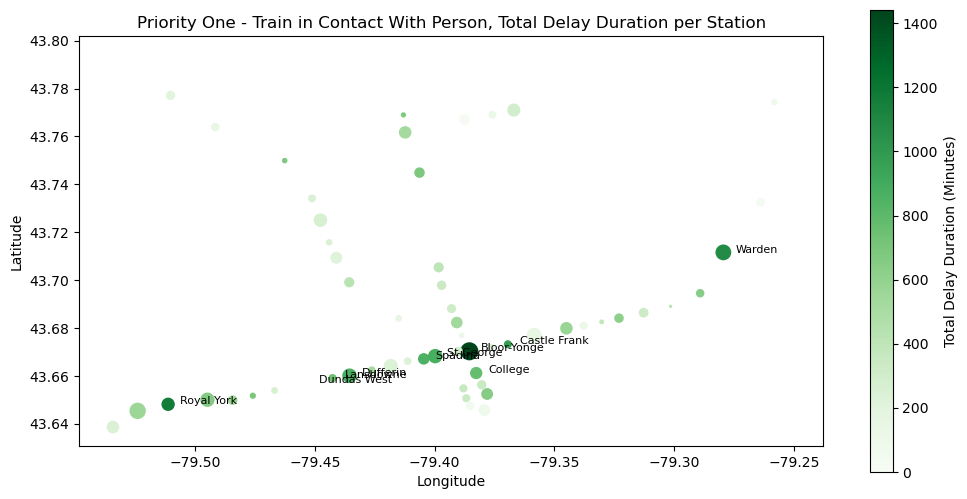

In [32]:
create_map('Priority One - Train in Contact With Person', 
           title = 'Priority One - Train in Contact With Person, Total Delay Duration per Station',
           color = 'Greens')

In [111]:
station_cause('Priority One - Train in Contact With Person')

station_clean  total_occurrence  delay_duration  average_delay
4    Bloor-Yonge                24            1442      60.083333
43    Royal York                10            1166     116.600000
59        Warden                13            1076      82.769231
6   Castle Frank                12             980      81.666667
14   Dundas West                 9             903     100.333333
53     St George                13             875      67.307692
12      Dufferin                 9             868      96.444444
49       Spadina                13             859      66.076923
8        College                13             768      59.076923
30     Lansdowne                 9             738      82.000000

In terms of total delay duration, Bloor-Yonge Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [113]:
linear_regression_table_cause('Priority One - Train in Contact With Person')

station_clean         slope    intercept  r-value  p-value  std_err  \
17       Finch West  1.686289e-06 -2641.609272      1.0      0.0      0.0   
13           Dupont  1.553340e-06 -2351.024070      1.0      0.0      0.0   
30    Lawrence West  1.472749e-06 -2110.368263      1.0      0.0      0.0   
47        St Andrew  4.056631e-07  -619.776561      1.0      0.0      0.0   
53            Union  3.353184e-07  -481.154032      1.0      0.0      0.0   
40         Rosedale  1.951058e-07  -256.035714      1.0      0.0      0.0   
25          Kennedy  1.086201e-07  -159.950991      1.0      0.0      0.0   
9          Donlands -5.787037e-07   888.100000     -1.0      0.0      0.0   
60         Yorkdale -5.906930e-07  1078.772107     -1.0      0.0      0.0   
38  Pioneer Village -1.190588e-06  2037.364250     -1.0      0.0      0.0   
29         Lawrence -1.593887e-06  2661.557203     -1.0      0.0      0.0   

   pval < 0.05 pval < 0.01  
17           Y           Y  
13           Y           Y  
30           Y           Y  
47           Y           Y  
53           Y           Y  
40           Y           Y  
25           Y           Y  
9            Y           Y  
60           Y           Y  
38           Y           Y  
29           Y           Y

### Injured or ill Customer (On Train) - Medical Aid Refused

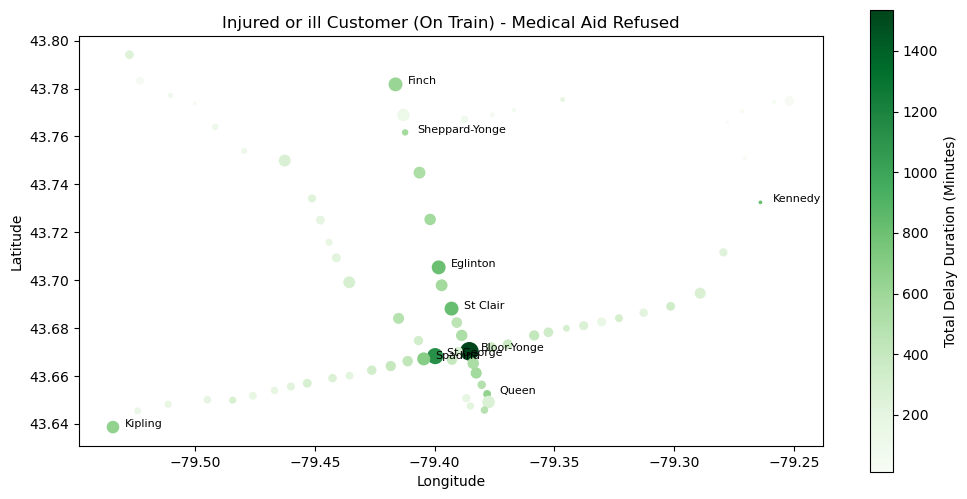

In [126]:
create_map('Injured or ill Customer (On Train) - Medical Aid Refused', 
           title = 'Injured or ill Customer (On Train) - Medical Aid Refused',
           color = 'Greens')

In [127]:
station_cause('Injured or ill Customer (On Train) - Medical Aid Refused')

station_clean  total_occurrence  delay_duration  average_delay
4      Bloor-Yonge               490            1535       3.132653
61       St George               283            1125       3.975265
59        St Clair               187             819       4.379679
31         Kennedy               295             814       2.759322
19        Eglinton               261             811       3.107280
57         Spadina               163             695       4.263804
33         Kipling               198             649       3.277778
49           Queen               149             649       4.355705
22           Finch               211             618       2.928910
55  Sheppard-Yonge               135             574       4.251852

In terms of total delay duration, Bloor-Yonge Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that only 5 of the stations in the Top 10 have worsening delay durations with very strong statistical significance: St Clair, Eglinton, Queen, Kipling, and Finch.

In [128]:
linear_regression_table_cause('Injured or ill Customer (On Train) - Medical Aid Refused')

station_clean         slope  intercept   r-value   p-value       std_err  \
73        Yorkdale  4.746843e-08 -67.183735  0.666980  0.000042  9.846764e-09   
39     Main Street  3.505724e-08 -46.833179  0.476548  0.000617  9.535733e-09   
47            Pape  2.900947e-08 -38.463095  0.378903  0.007913  1.044669e-08   
25       Greenwood  2.759369e-08 -37.625466  0.486354  0.006428  9.368539e-09   
59        St Clair  2.538372e-08 -30.970015  0.328011  0.001038  7.500444e-09   
55  Sheppard-Yonge  2.400721e-08 -30.308774  0.319634  0.003224  7.907606e-09   
8         Christie  2.173606e-08 -26.934543  0.349308  0.005391  7.527313e-09   
19        Eglinton  2.167388e-08 -25.499862  0.268806  0.006567  7.805389e-09   
49           Queen  1.791511e-08 -20.325174  0.274444  0.009665  6.768812e-09   
33         Kipling  1.685692e-08 -19.339685  0.325529  0.001452  5.132673e-09   
22           Finch  1.625875e-08 -19.180544  0.312570  0.001634  5.016821e-09   

   pval < 0.05 pval < 0.01  
73           Y           Y  
39           Y           Y  
47           Y           Y  
25           Y           Y  
59           Y           Y  
55           Y           Y  
8            Y           Y  
19           Y           Y  
49           Y           Y  
33           Y           Y  
22           Y           Y

## Equipment Related Category

We'll look at the delay causes under the Equipment Related Category with the highest slopes when we conducted linear regression previously. We said that these delay causes exhibited worsening delay durations with very strong statistical significance. Note that these delay causes might not necessarily be the top delay causes in terms of delay duration.

We'll also conduct linear regression analysis per delay cause per Station.

### Unsanitary Vehicle

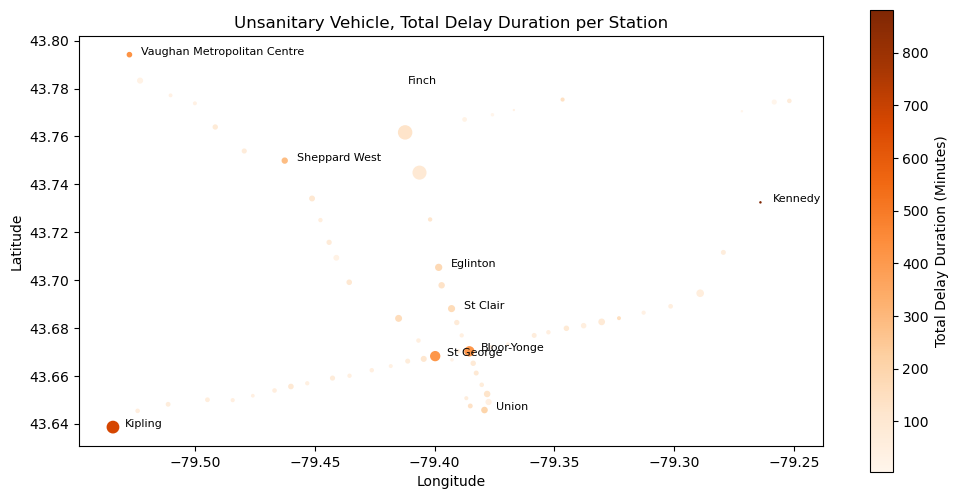

In [34]:
create_map('Unsanitary Vehicle', 
           title = 'Unsanitary Vehicle, Total Delay Duration per Station',
           color = 'Oranges')

In [35]:
station_cause('Unsanitary Vehicle')

station_clean  total_occurrence  delay_duration  \
30                      Kennedy               230             881   
21                        Finch               222             830   
32                      Kipling               186             672   
63  Vaughan Metropolitan Centre               111             424   
4                   Bloor-Yonge                90             412   
59                    St George                83             410   
52                Sheppard West                66             285   
62                        Union                42             200   
19                     Eglinton                38             177   
57                     St Clair                28             168   

    average_delay  
30       3.830435  
21       3.738739  
32       3.612903  
63       3.819820  
4        4.577778  
59       4.939759  
52       4.318182  
62       4.761905  
19       4.657895  
57       6.000000

In terms of total delay duration, Kennedy Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that only a few of the stations in the Top 10 have worsening delay durations with very strong statistical significance: Kennedy, Kipling, Bloor-Yonge, St George, and Union.

In [115]:
linear_regression_table_cause('Unsanitary Vehicle')

station_clean         slope  intercept   r-value   p-value       std_err  \
56     St George  3.169956e-08 -42.825750  0.435394  0.001768  9.560484e-09   
31       Kipling  2.884263e-08 -38.037951  0.477143  0.000001  5.538537e-09   
29       Kennedy  2.504291e-08 -30.720373  0.450266  0.000001  4.893244e-09   
59         Union  2.006285e-08 -24.941417  0.546522  0.003183  6.148525e-09   
3    Bloor-Yonge  1.711291e-08 -19.795176  0.368545  0.003472  5.619625e-09   

   pval < 0.05 pval < 0.01  
56           Y           Y  
31           Y           Y  
29           Y           Y  
59           Y           Y  
3            Y           Y

### Work Zone Problems - Track

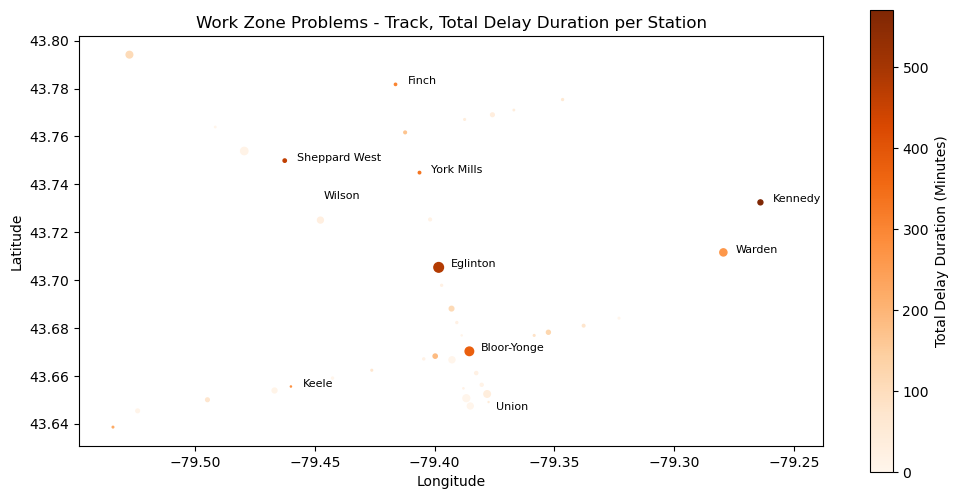

In [36]:
create_map('Work Zone Problems - Track', 
           title = 'Work Zone Problems - Track, Total Delay Duration per Station',
           color = 'Oranges')

In [37]:
station_cause('Work Zone Problems - Track')

station_clean  total_occurrence  delay_duration  average_delay
24        Kennedy                34             571      16.794118
16       Eglinton                57             480       8.421053
40  Sheppard West                21             461      21.952381
2     Bloor-Yonge                38             378       9.947368
57     York Mills                38             334       8.789474
17          Finch                24             303      12.625000
23          Keele                28             278       9.928571
53         Warden                12             265      22.083333
55         Wilson                27             239       8.851852
50          Union                31             228       7.354839

In terms of total delay duration, Kennedy Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [116]:
linear_regression_table_cause('Work Zone Problems - Track')

station_clean         slope   intercept   r-value   p-value       std_err  \
1      Bessarion  4.988825e-08  -62.646552  1.000000  0.000000  0.000000e+00   
11        Dundas  1.998977e-08  -28.063903  1.000000  0.000000  0.000000e+00   
18     Islington -3.454947e-08   57.602985 -1.000000  0.000000  0.000000e+00   
4   Castle Frank -1.163613e-07  197.674263 -1.000000  0.000000  0.000000e+00   
26        Leslie -1.989294e-07  354.553125 -1.000000  0.000000  0.000000e+00   
17     High Park -2.656345e-07  454.036066 -1.000000  0.000000  0.000000e+00   
5        Chester -5.248048e-07  842.062196 -0.995286  0.004714  3.616059e-08   

   pval < 0.05 pval < 0.01  
1            Y           Y  
11           Y           Y  
18           Y           Y  
4            Y           Y  
26           Y           Y  
17           Y           Y  
5            Y           Y

### Consequential Delay (2nd Delay Same Fault)

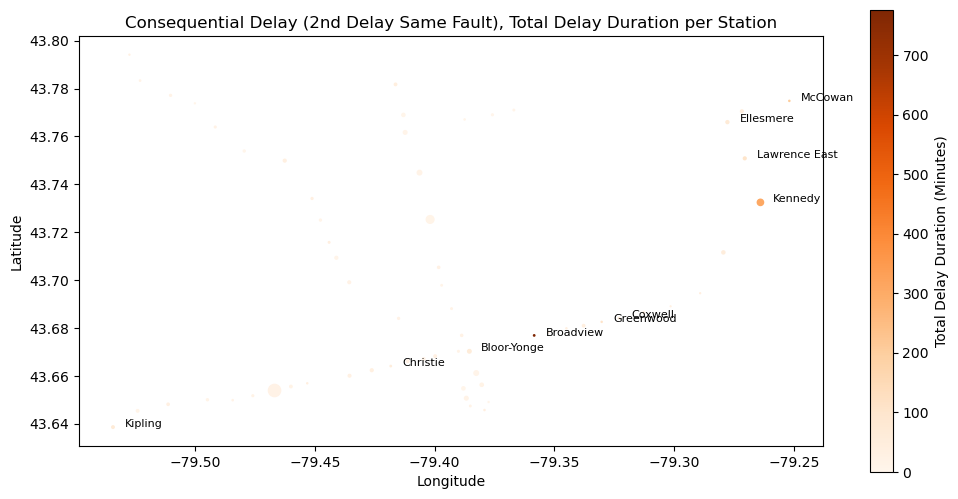

In [38]:
create_map('Consequential Delay (2nd Delay Same Fault)', 
           title = 'Consequential Delay (2nd Delay Same Fault), Total Delay Duration per Station',
           color = 'Oranges')

In [39]:
station_cause('Consequential Delay (2nd Delay Same Fault)')

station_clean  total_occurrence  delay_duration  average_delay
5       Broadview                13             776      59.692308
29        Kennedy                67             308       4.597015
38        McCowan                33             205       6.212121
23      Greenwood                13             108       8.307692
34  Lawrence East                10             106      10.600000
31        Kipling                19              69       3.631579
19      Ellesmere                 6              68      11.333333
4     Bloor-Yonge                15              63       4.200000
10        Coxwell                13              55       4.230769
8        Christie                11              53       4.818182

In terms of total delay duration, Broadview Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that only one of the stations in the Top 10 have worsening delay durations with very strong statistical significance: Kennedy.

In [117]:
linear_regression_table_cause('Consequential Delay (2nd Delay Same Fault)')

station_clean         slope    intercept   r-value   p-value  \
43         Sherbourne  1.543210e-06 -2297.933333  1.000000  0.000000   
22          Islington  4.198860e-08   -62.587274  0.990570  0.009430   
25            Kennedy  3.482460e-08   -47.412010  0.402964  0.008995   
37    Pioneer Village  1.676592e-08   -20.481893  1.000000  0.000000   
53             Wilson  1.582043e-08   -21.295185  0.841916  0.002247   
9          Davisville  6.034449e-09    -4.251303  1.000000  0.000000   
29             Leslie -4.222574e-09     9.940533 -1.000000  0.000000   
56           Yorkdale -7.604516e-09    15.898160 -1.000000  0.000000   
12             Dundas -1.288872e-08    29.097996 -1.000000  0.000000   
7             College -2.305592e-08    39.986056 -1.000000  0.000000   
33  North York Centre -3.802258e-08    63.291721 -1.000000  0.000000   

         std_err pval < 0.05 pval < 0.01  
43  0.000000e+00           Y           Y  
22  4.106575e-09           Y           Y  
25  1.266516e-08           Y           Y  
37  0.000000e+00           Y           Y  
53  3.584959e-09           Y           Y  
9   0.000000e+00           Y           Y  
29  0.000000e+00           Y           Y  
56  0.000000e+00           Y           Y  
12  0.000000e+00           Y           Y  
7   0.000000e+00           Y           Y  
33  0.000000e+00           Y           Y

### Tarck Switch Failure - Signal Related Problem

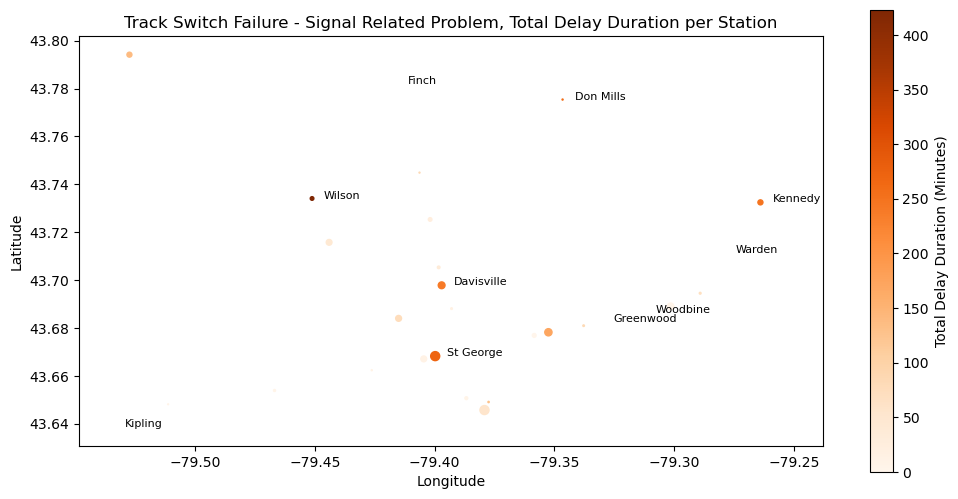

In [40]:
create_map('Track Switch Failure - Signal Related Problem', 
           title = 'Track Switch Failure - Signal Related Problem, Total Delay Duration per Station',
           color = 'Oranges')

In [ ]:
station_cause('Track Switch Failure - Signal Related Problem')

station_clean  total_occurrence  delay_duration  average_delay
39        Wilson                44             423       9.613636
38        Warden                21             423      20.142857
34     St George                16             272      17.000000
6      Don Mills                 8             261      32.625000
18       Kennedy                16             248      15.500000
40      Woodbine                21             248      11.809524
5     Davisville                35             239       6.828571
20       Kipling                31             228       7.354839
11         Finch                14             218      15.571429
13     Greenwood                27             185       6.851852

In terms of total delay duration, Wilson Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [118]:
linear_regression_table_cause('Track Switch Failure - Signal Related Problem')

station_clean         slope    intercept  r-value   p-value       std_err  \
12          Jane  2.112057e-07  -279.890511  1.00000  0.000000  0.000000e+00   
19        Museum  1.217798e-07  -189.090791  0.99991  0.008564  1.638384e-09   
3        Coxwell  9.712510e-08  -142.262937  1.00000  0.000000  0.000000e+00   
20     Ossington -1.811279e-08    32.912363 -1.00000  0.000000  0.000000e+00   
2       Christie -4.842709e-08    80.640167 -1.00000  0.000000  0.000000e+00   
25      St Clair -1.007415e-07   172.006770 -1.00000  0.000000  0.000000e+00   
9     Finch West -5.037073e-07   861.037718 -1.00000  0.000000  0.000000e+00   
17      Lawrence -2.276867e-06  3340.918033 -1.00000  0.000000  0.000000e+00   
23       Spadina -5.015432e-06  8625.500000 -1.00000  0.000000  0.000000e+00   

   pval < 0.05 pval < 0.01  
12           Y           Y  
19           Y           Y  
3            Y           Y  
20           Y           Y  
2            Y           Y  
25           Y           Y  
9            Y           Y  
17           Y           Y  
23           Y           Y

### Signals Axle Counter Block Failure

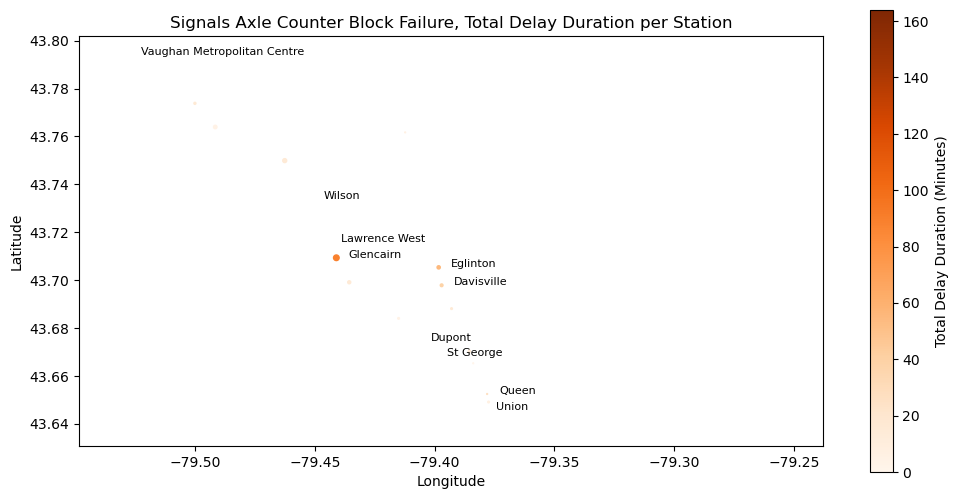

In [42]:
create_map('Signals Axle Counter Block Failure', 
           title = 'Signals Axle Counter Block Failure, Total Delay Duration per Station',
           color = 'Oranges')

In [43]:
station_cause('Signals Axle Counter Block Failure')

station_clean  total_occurrence  delay_duration  \
4                        Dupont                35             164   
9                     Glencairn                17              89   
30                       Wilson                20              81   
27                        Union                10              66   
25                    St George                12              63   
5                      Eglinton                 7              55   
12                Lawrence West                 8              48   
2                    Davisville                 7              39   
28  Vaughan Metropolitan Centre                 3              31   
17                        Queen                 7              27   

    average_delay  
4        4.685714  
9        5.235294  
30       4.050000  
27       6.600000  
25       5.250000  
5        7.857143  
12       6.000000  
2        5.571429  
28      10.333333  
17       3.857143

In terms of total delay duration, Dupont Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [119]:
linear_regression_table_cause('Signals Axle Counter Block Failure')

station_clean         slope    intercept  r-value  p-value  std_err  \
14           St Clair  1.224050e-07  -198.193890      1.0      0.0      0.0   
6       Eglinton West -8.591571e-08   150.851538     -1.0      0.0      0.0   
10  North York Centre -1.516254e-07   261.170306     -1.0      0.0      0.0   
3              Dundas -2.112057e-07   362.116788     -1.0      0.0      0.0   
15      St Clair West -7.467145e-07  1288.193548     -1.0      0.0      0.0   
21    York University -7.631258e-07  1303.373626     -1.0      0.0      0.0   

   pval < 0.05 pval < 0.01  
14           Y           Y  
6            Y           Y  
10           Y           Y  
3            Y           Y  
15           Y           Y  
21           Y           Y

## Personnel Related Category

We'll look at the delay causes under the Personnel Related Category with the highest slopes when we conducted linear regression previously. We said that these delay causes exhibited worsening delay durations with very strong statistical significance. Note that these delay causes might not necessarily be the top delay causes in terms of delay duration.

We'll also conduct linear regression analysis per delay cause per Station.

### OPTO (COMMS) Train Door Monitoring

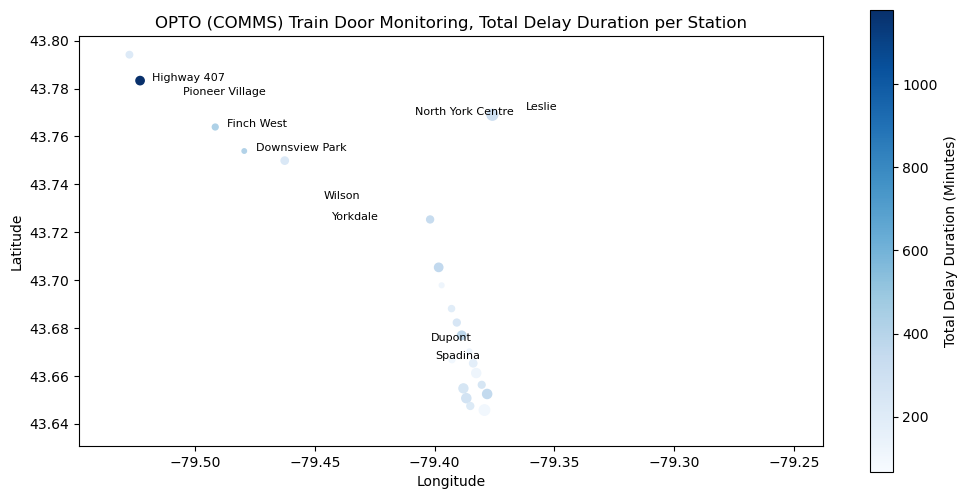

In [44]:
create_map('OPTO (COMMS) Train Door Monitoring', 
           title = 'OPTO (COMMS) Train Door Monitoring, Total Delay Duration per Station',
           color = 'Blues')

In [45]:
station_cause('OPTO (COMMS) Train Door Monitoring')

station_clean  total_occurrence  delay_duration  average_delay
14        Highway 407               299            1179       3.943144
40           Yorkdale               226             930       4.115044
18             Leslie               130             648       4.984615
27            Spadina               146             607       4.157534
37             Wilson               194             562       2.896907
20  North York Centre               114             488       4.280702
12         Finch West               110             430       3.909091
22    Pioneer Village               129             430       3.333333
8              Dupont                94             423       4.500000
6      Downsview Park               117             416       3.555556

In terms of total delay duration, Highway 407 Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that only one of the stations in the Top 10 have worsening delay durations with very strong statistical significance: Highway 407.

In [120]:
linear_regression_table_cause('OPTO (COMMS) Train Door Monitoring')

station_clean         slope   intercept   r-value   p-value  \
16        Lawrence  4.941831e-07 -822.262748  0.635388  0.001967   
21         Osgoode  4.616687e-07 -770.575322  0.555813  0.007236   
33      Summerhill  3.676412e-07 -612.342316  0.643784  0.001225   
26  Sheppard-Yonge  9.431123e-08 -149.497381  0.508587  0.002510   
2      Bloor-Yonge -4.215786e-08   74.486645 -0.612897  0.001875   
31       St George -1.591545e-07  275.509590 -0.584574  0.000554   
14     Highway 407 -4.672447e-07  814.325311 -0.473898  0.002652   

         std_err pval < 0.05 pval < 0.01  
16  1.377836e-07           Y           Y  
21  1.544005e-07           Y           Y  
33  9.771203e-08           Y           Y  
26  2.867647e-08           Y           Y  
2   1.186037e-08           Y           Y  
31  4.101882e-08           Y           Y  
14  1.447029e-07           Y           Y

### Transportation Department - Other

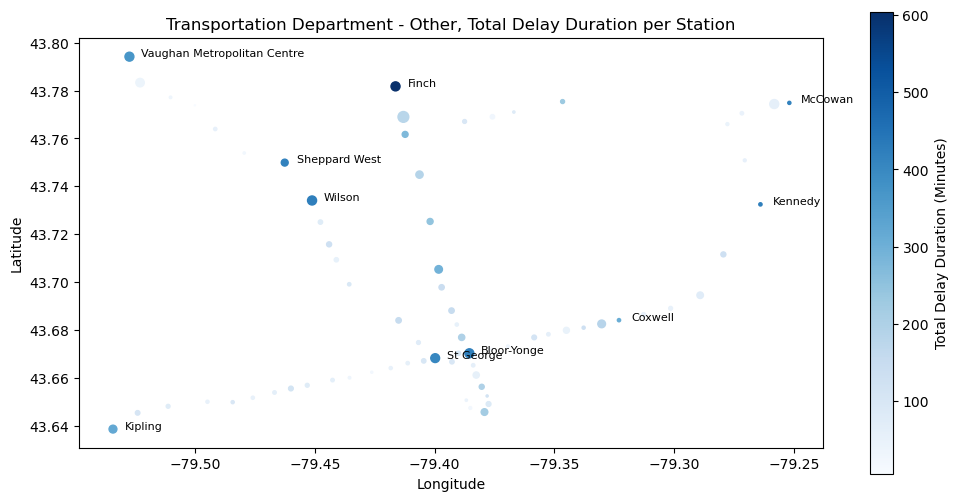

In [46]:
create_map('Transportation Department - Other', 
           title = 'Transportation Department - Other, Total Delay Duration per Station',
           color = 'Blues')

In [47]:
station_cause('Transportation Department - Other')

station_clean  total_occurrence  delay_duration  \
22                        Finch               154             604   
31                      Kennedy               124             424   
69                       Wilson               101             424   
4                   Bloor-Yonge               122             422   
40                      McCowan                80             417   
54                Sheppard West                98             415   
61                    St George                78             404   
65  Vaughan Metropolitan Centre                87             369   
33                      Kipling                89             320   
10                      Coxwell                65             308   

    average_delay  
22       3.922078  
31       3.419355  
69       4.198020  
4        3.459016  
40       5.212500  
54       4.234694  
61       5.179487  
65       4.241379  
33       3.595506  
10       4.738462

In terms of total delay duration, Finch Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [121]:
linear_regression_table_cause('Transportation Department - Other')

station_clean         slope  intercept   r-value   p-value       std_err  \
16        Dundas  6.244371e-08 -94.791117  0.561092  0.005345  2.010232e-08   
9        College  2.553788e-08 -36.075095  0.718976  0.005614  7.443556e-09   
29          Jane -1.285167e-08  24.047924 -0.495809  0.010000  4.594885e-09   

   pval < 0.05 pval < 0.01  
16           Y           Y  
9            Y           Y  
29           Y           Y

### Operator Violated Signal

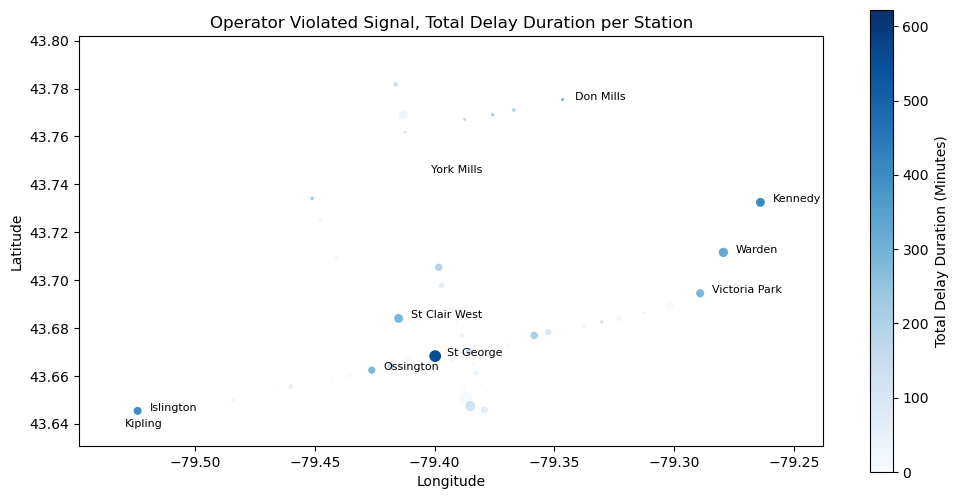

In [48]:
create_map('Operator Violated Signal', 
           title = 'Operator Violated Signal, Total Delay Duration per Station',
           color = 'Blues')

In [49]:
station_cause('Operator Violated Signal')

station_clean  total_occurrence  delay_duration  average_delay
30        Kipling               255             622       2.439216
53      St George               184             555       3.016304
63     York Mills               157             439       2.796178
28        Kennedy               308             407       1.321429
25      Islington               214             399       1.864486
59         Warden               212             321       1.514151
12      Don Mills               171             288       1.684211
52  St Clair West               123             288       2.341463
58  Victoria Park               162             285       1.759259
40      Ossington                87             282       3.241379

In terms of total delay duration, Kipling Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that a few of the stations in the Top 10 have worsening delay durations with very strong statistical significance: York Mills, Islington, Warden, and Ossington.

In [122]:
linear_regression_table_cause('Operator Violated Signal')

station_clean         slope  intercept   r-value   p-value       std_err  \
37     Ossington  4.029174e-08 -57.568249  0.544517  0.000014  8.445791e-09   
56    York Mills  3.429741e-08 -46.909753  0.389849  0.000596  9.547767e-09   
11    Davisville  2.632154e-08 -38.003255  0.428051  0.003354  8.474859e-09   
23     Islington  2.194546e-08 -30.237424  0.316764  0.001249  6.604364e-09   
38         Queen  2.114851e-08 -30.461278  0.581368  0.001176  5.804630e-09   
5      Broadview  1.963227e-08 -27.167165  0.464608  0.000272  5.045437e-09   
49    Summerhill  1.455384e-08 -21.481516  0.658747  0.007570  4.610155e-09   
52        Warden  1.210882e-08 -15.729166  0.276558  0.004686  4.186756e-09   
15   Dundas West  1.054256e-08 -14.393935  0.379138  0.000318  2.807445e-09   
35      Old Mill  9.541022e-09 -13.566205  0.301687  0.008086  3.505108e-09   

   pval < 0.05 pval < 0.01  
37           Y           Y  
56           Y           Y  
11           Y           Y  
23           Y           Y  
38           Y           Y  
5            Y           Y  
49           Y           Y  
52           Y           Y  
15           Y           Y  
35           Y           Y

### Crew Unable to Maintain Schedule

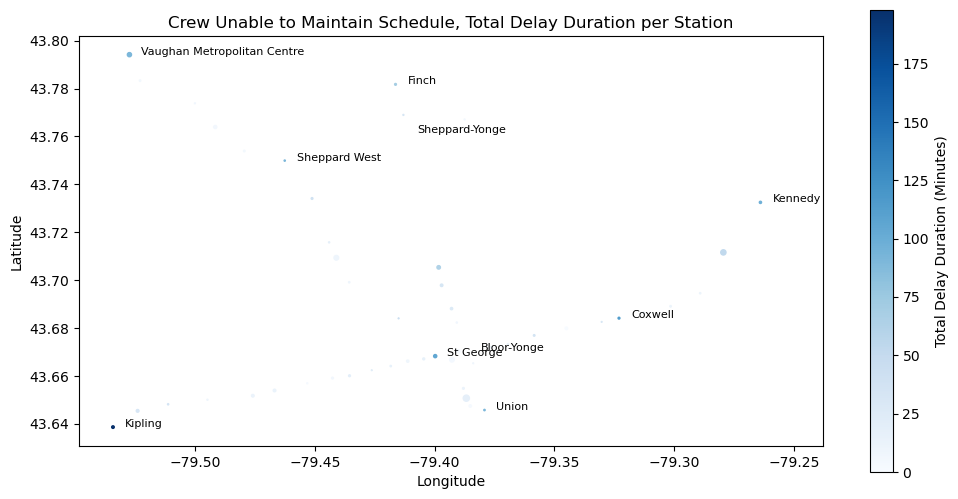

In [50]:
create_map('Crew Unable to Maintain Schedule', 
           title = 'Crew Unable to Maintain Schedule, Total Delay Duration per Station',
           color = 'Blues')

In [51]:
station_cause('Crew Unable to Maintain Schedule')

station_clean  total_occurrence  delay_duration  \
27                      Kipling                37             198   
3                   Bloor-Yonge                29             143   
7                       Coxwell                24             114   
48                    St George                20             105   
26                      Kennedy                19              97   
41                Sheppard West                12              92   
52  Vaughan Metropolitan Centre                15              91   
51                        Union                18              91   
42               Sheppard-Yonge                12              85   
17                        Finch                10              70   

    average_delay  
27       5.351351  
3        4.931034  
7        4.750000  
48       5.250000  
26       5.105263  
41       7.666667  
52       6.066667  
51       5.055556  
42       7.083333  
17       7.000000

In terms of total delay duration, Kipling Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [123]:
linear_regression_table_cause('Crew Unable to Maintain Schedule')

station_clean         slope   intercept  r-value  p-value  std_err  \
0        Bathurst  3.807261e-08  -59.476974      1.0      0.0      0.0   
31     Sherbourne  2.716919e-08  -41.298122      1.0      0.0      0.0   
11  Eglinton West  1.246535e-08  -13.602585      1.0      0.0      0.0   
37     Summerhill  1.118268e-08  -15.291787      1.0      0.0      0.0   
44       Woodbine  6.553836e-09   -6.219706      1.0      0.0      0.0   
3    Castle Frank -9.510332e-09   22.130649     -1.0      0.0      0.0   
7       Don Mills -2.112057e-08   38.213504     -1.0      0.0      0.0   
21  Lawrence West -4.568713e-07  786.907895     -1.0      0.0      0.0   

   pval < 0.05 pval < 0.01  
0            Y           Y  
31           Y           Y  
11           Y           Y  
37           Y           Y  
44           Y           Y  
3            Y           Y  
7            Y           Y  
21           Y           Y

### Supervisory Error

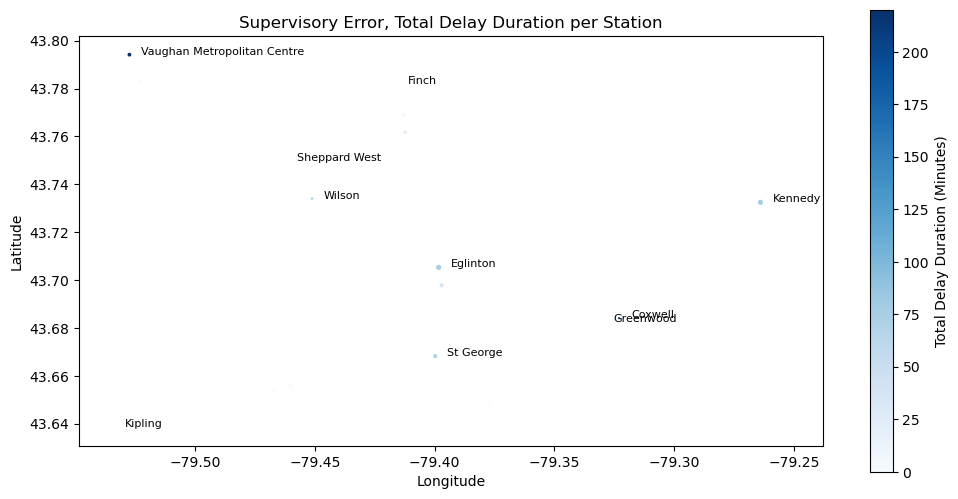

In [52]:
create_map('Supervisory Error', 
           title = 'Supervisory Error, Total Delay Duration per Station',
           color = 'Blues')

In [53]:
station_cause('Supervisory Error')

station_clean  total_occurrence  delay_duration  \
35  Vaughan Metropolitan Centre                37             220   
9                         Finch                46             204   
3                       Coxwell                41             204   
27                Sheppard West                25             138   
15                      Kennedy                18              77   
10                    Greenwood                12              75   
38                       Wilson                18              75   
8                      Eglinton                19              75   
32                    St George                 9              70   
17                      Kipling                15              45   

    average_delay  
35       5.945946  
9        4.434783  
3        4.975610  
27       5.520000  
15       4.277778  
10       6.250000  
38       4.166667  
8        3.947368  
32       7.777778  
17       3.000000

In terms of total delay duration, Vaughan Metropolitan Centre Station had the longest historically.

Conducting linear regression on the stations with this delay cause, we can see that none of the stations in the Top 10 have worsening delay durations with very strong statistical significance.

In [124]:
linear_regression_table_cause('Supervisory Error')

station_clean         slope   intercept  r-value  p-value  std_err  \
10    Highway 407  8.150756e-08 -135.676056      1.0      0.0      0.0   
18      St Andrew  6.003842e-08  -80.882997      1.0      0.0      0.0   
6     Dundas West -1.296089e-08   22.324748     -1.0      0.0      0.0   
23  Victoria Park -1.953430e-08   38.491983     -1.0      0.0      0.0   
0       Bessarion -1.007415e-07  174.139265     -1.0      0.0      0.0   

   pval < 0.05 pval < 0.01  
10           Y           Y  
18           Y           Y  
6            Y           Y  
23           Y           Y  
0            Y           Y

# Stations

## Bloor-Yonge Station

Bloor-Yonge Station was Top 1 in terms of delay duration for delay causes Disorderly Patron, Unauthorized at Track Level, Passenger Assistance Alarm Activated - No Trouble Found, Priority One - Train in Contact With Person, Injured or ill Customer (On Train) - Medical Aid Refused. The first four delay causes had very strong statistical significance.

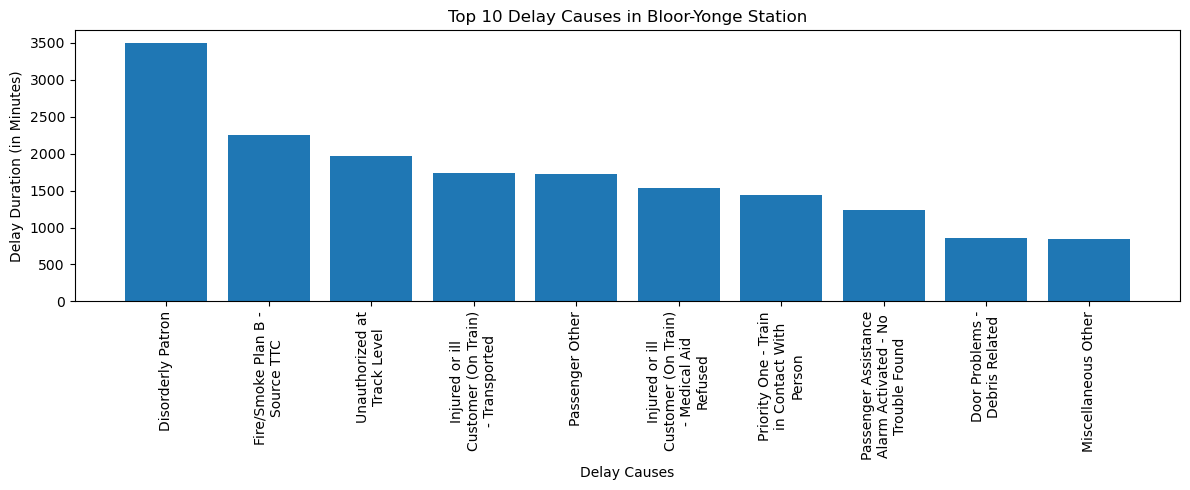

In [59]:
create_bar_chart('Bloor-Yonge')

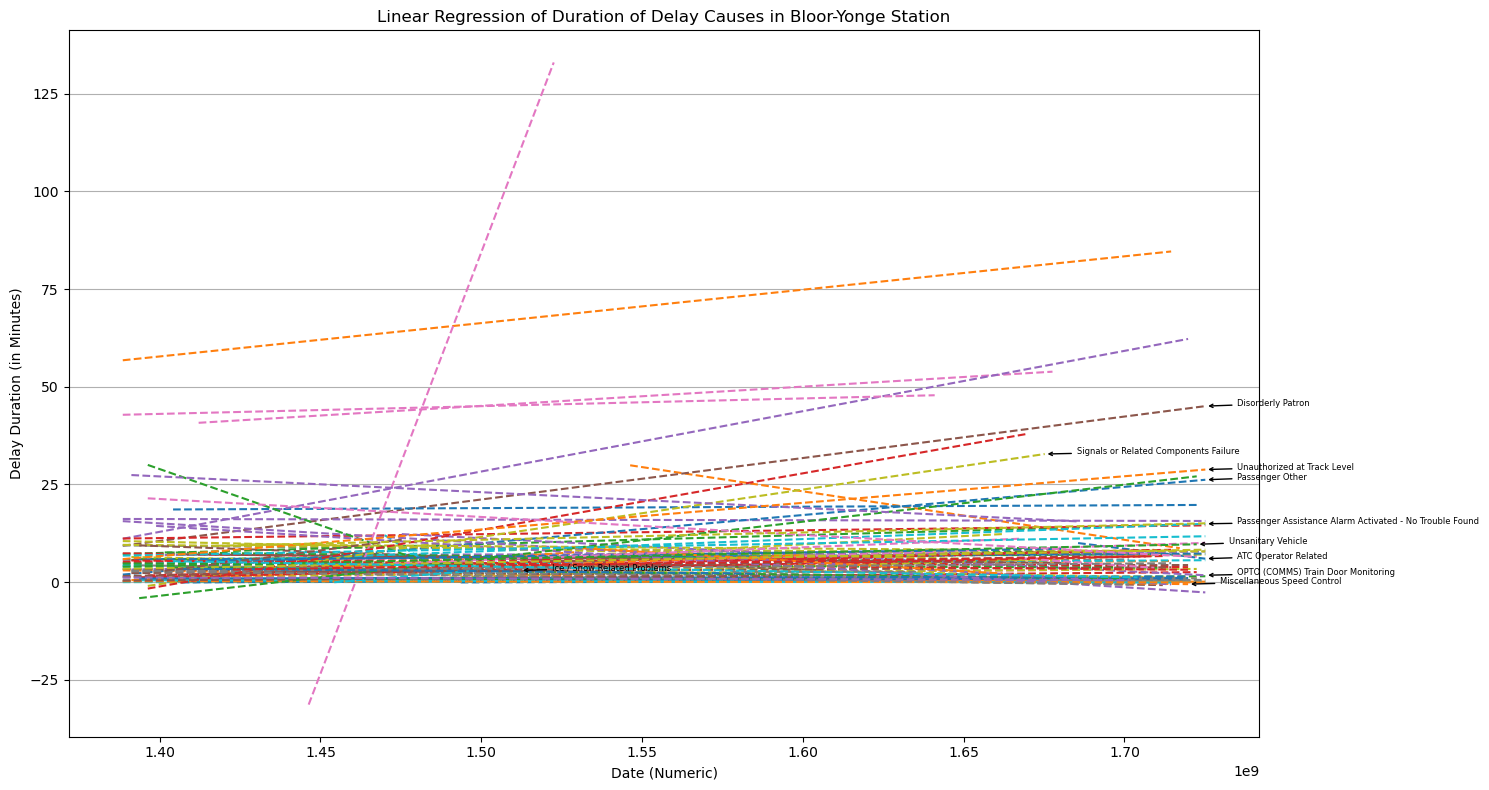

In [57]:
linear_regression_plot('Bloor-Yonge')

In [58]:
linear_regression_table('Bloor-Yonge')

delay_cause         slope  \
68              Signals or Related Components Failure  1.210232e-07   
15                                  Disorderly Patron  1.061293e-07   
50                                    Passenger Other  7.209800e-08   
91                        Unauthorized at Track Level  6.808150e-08   
49  Passenger Assistance Alarm Activated - No Trou...  3.125487e-08   
92                                 Unsanitary Vehicle  1.711291e-08   
29                        Ice / Snow Related Problems -8.093758e-09   
41                        Miscellaneous Speed Control -1.062409e-08   
44                 OPTO (COMMS) Train Door Monitoring -4.215786e-08   
0                                ATC Operator Related -1.010836e-07   

     intercept   r-value       p-value       std_err pval < 0.05 pval < 0.01  
68 -169.950998  0.623437  5.702728e-03  3.794483e-08           Y           Y  
15 -138.041245  0.549600  1.835961e-11  1.437185e-08           Y           Y  
50  -98.179521  0.325611  3.021015e-04  1.935508e-08           Y           Y  
91  -88.636227  0.356075  1.930279e-04  1.760467e-08           Y           Y  
49  -38.989403  0.327910  1.577671e-04  8.021860e-09           Y           Y  
92  -19.795176  0.368545  3.472195e-03  5.619625e-09           Y           Y  
29   15.238462 -1.000000  0.000000e+00  0.000000e+00           Y           Y  
41   17.752600 -0.312997  1.028822e-03  3.146068e-09           Y           Y  
44   74.486645 -0.612897  1.874823e-03  1.186037e-08           Y           Y  
0   180.384279 -1.000000  0.000000e+00  0.000000e+00           Y           Y

## Kennedy Station

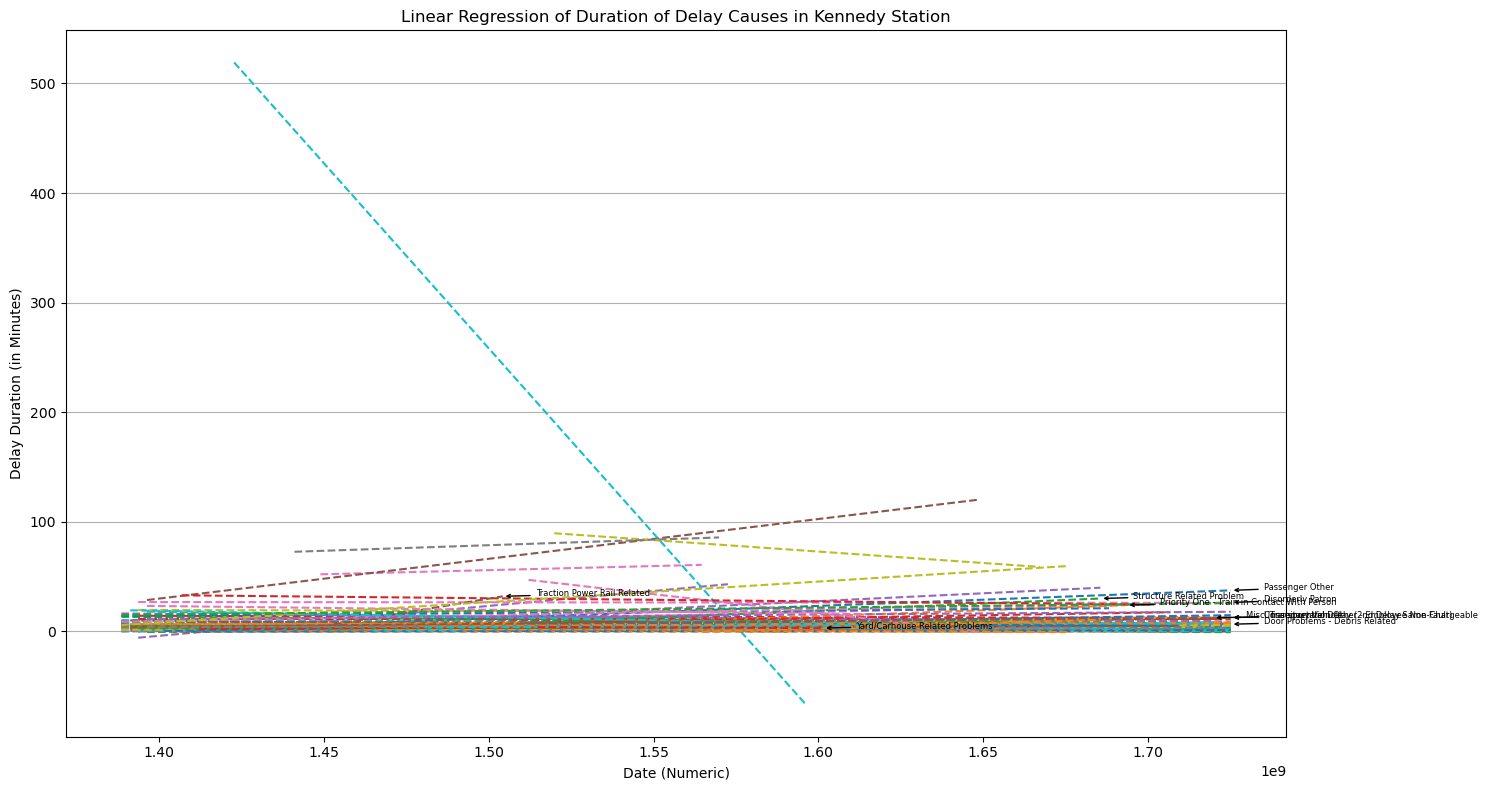

In [54]:
linear_regression_plot('Kennedy')

In [55]:
linear_regression_table('Kennedy')

delay_cause         slope  \
85                         Traction Power Rail Related  5.009674e-07   
72                           Structure Related Problem  1.282209e-07   
50                                     Passenger Other  1.132415e-07   
51         Priority One - Train in Contact With Person  1.086201e-07   
16                                   Disorderly Patron  6.930124e-08   
11          Consequential Delay (2nd Delay Same Fault)  3.482460e-08   
95                                  Unsanitary Vehicle  2.504291e-08   
40   Misc. Transportation Other - Employee Non-Char...  2.241520e-08   
18                      Door Problems - Debris Related  1.089120e-08   
103                     Yard/Carhouse Related Problems -1.152796e-08   

      intercept   r-value   p-value       std_err pval < 0.05 pval < 0.01  
85  -721.567164  1.000000  0.000000  0.000000e+00           Y           Y  
72  -186.126292  1.000000  0.000000  0.000000e+00           Y           Y  
50  -157.919964  0.356057  0.000398  3.081825e-08           Y           Y  
51  -159.950991  1.000000  0.000000  0.000000e+00           Y           Y  
16   -93.156065  0.367296  0.000027  1.588827e-08           Y           Y  
11   -47.412010  0.402964  0.008995  1.266516e-08           Y           Y  
95   -30.720373  0.450266  0.000001  4.893244e-09           Y           Y  
40   -26.042355  0.315976  0.002280  7.134329e-09           Y           Y  
18   -12.239778  0.338806  0.003601  3.614925e-09           Y           Y  
103   21.462151 -1.000000  0.000000  0.000000e+00           Y           Y

We can see from the above table and chart that certain delay causes have since been resolved permanently. For instance, for Traction Power Rail Related delay cause, the chart above shows that it sometime around 2018. The same can be said about Structure Related Problem. The nature of these delay causes may be that they are construction- or project-related. Once the project ended, so has the delay it was causing.

Points of interest are Passenger Other, Priority One -Train in Contact With Person, Disorderly Patron, Consequential Delay (2nd Delay Same Fault), and Unsanitary Vehicle, all of which are worsening with very strong statistical significance. These five (5) delay causes were also noted in the preceding EDA.

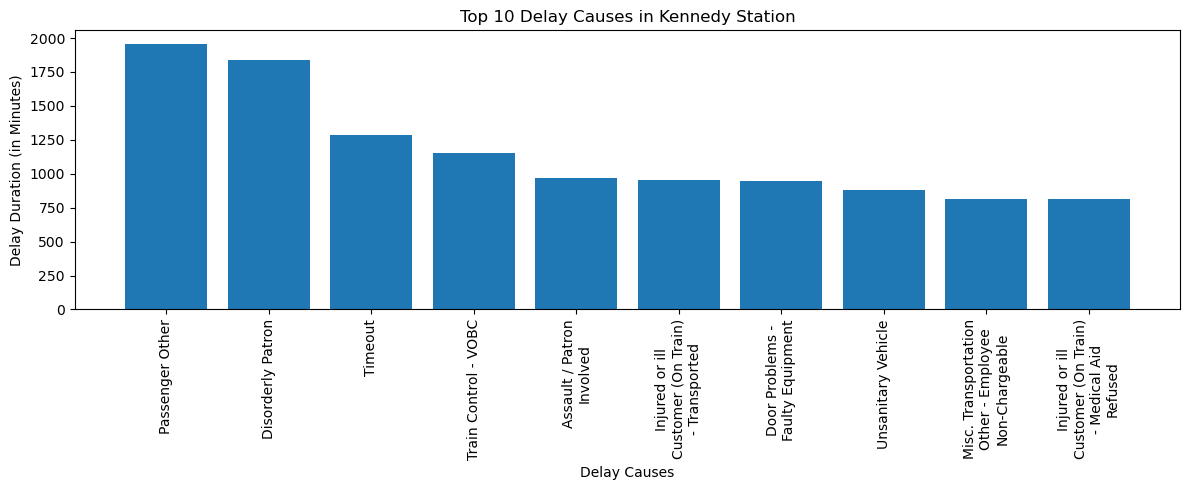

In [56]:
create_bar_chart('Kennedy')

## St. George Station

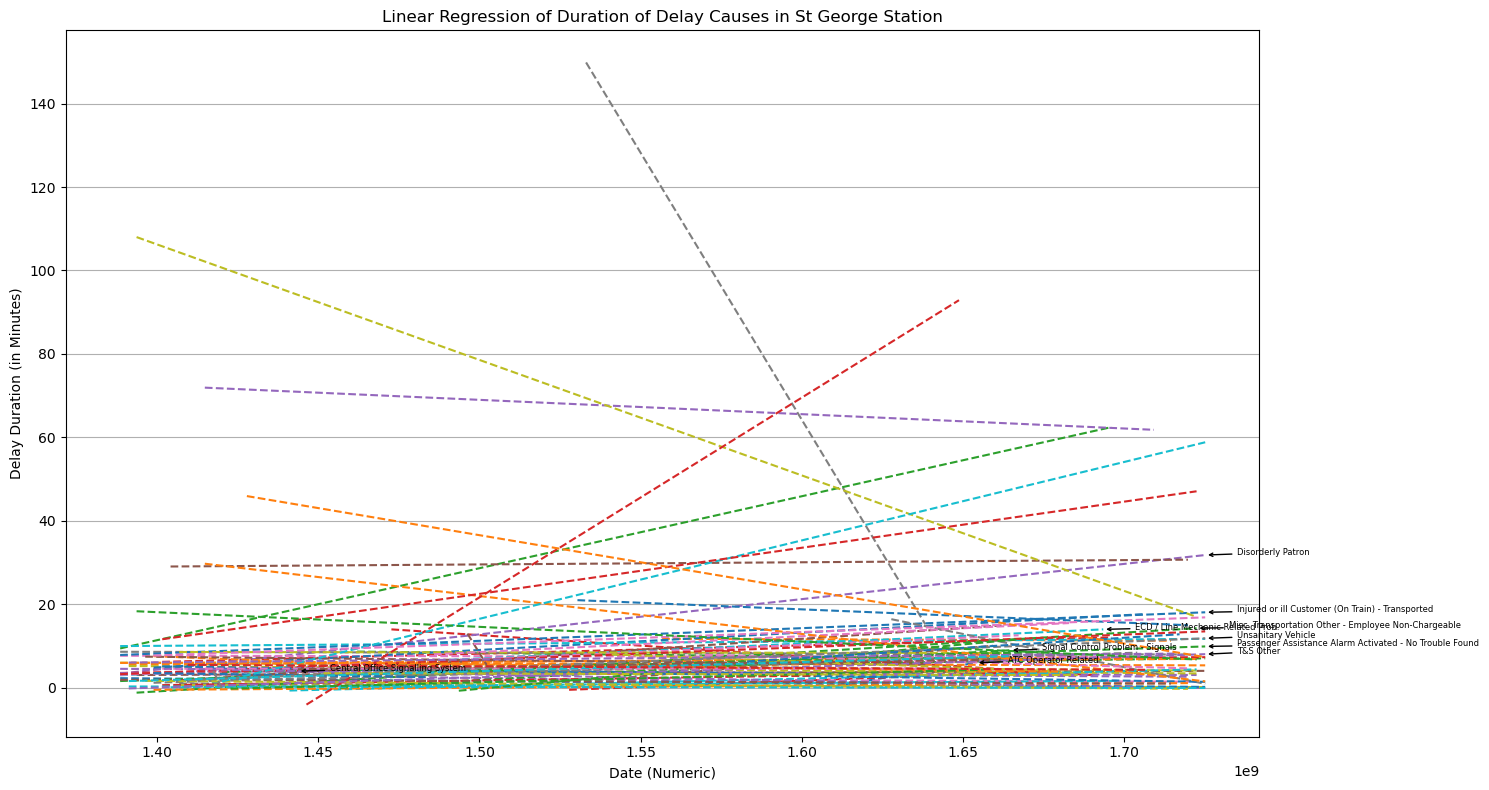

In [60]:
linear_regression_plot('St George')

In [61]:
linear_regression_table('St George')

delay_cause         slope  \
0                                ATC Operator Related  1.269551e-07   
9                    Central Office Signalling System  1.086768e-07   
14                                  Disorderly Patron  8.440905e-08   
32  Misc. Transportation Other - Employee Non-Char...  4.695587e-08   
52                   Signal Control Problem - Signals  4.331254e-08   
19                  ECD / Line Mechanic Related Prob.  3.606652e-08   
77                                 Unsanitary Vehicle  3.169956e-08   
30   Injured or ill Customer (On Train) - Transported  3.038062e-08   
42  Passenger Assistance Alarm Activated - No Trou...  2.462127e-08   
64                                          T&S Other  2.457123e-08   

     intercept   r-value       p-value       std_err pval < 0.05 pval < 0.01  
0  -203.989031  1.000000  0.000000e+00  0.000000e+00           Y           Y  
9  -152.892019  1.000000  0.000000e+00  0.000000e+00           Y           Y  
14 -113.807332  0.481901  2.189951e-08  1.406934e-08           Y           Y  
32  -66.603861  0.507488  7.667797e-05  1.095119e-08           Y           Y  
52  -63.097297  1.000000  0.000000e+00  0.000000e+00           Y           Y  
19  -47.079603  1.000000  0.000000e+00  0.000000e+00           Y           Y  
77  -42.825750  0.435394  1.767902e-03  9.560484e-09           Y           Y  
30  -34.316907  0.291207  4.195384e-03  1.034931e-08           Y           Y  
42  -32.563051  0.393736  5.551983e-06  5.182906e-09           Y           Y  
64  -34.332812  0.784029  9.034838e-04  5.615695e-09           Y           Y

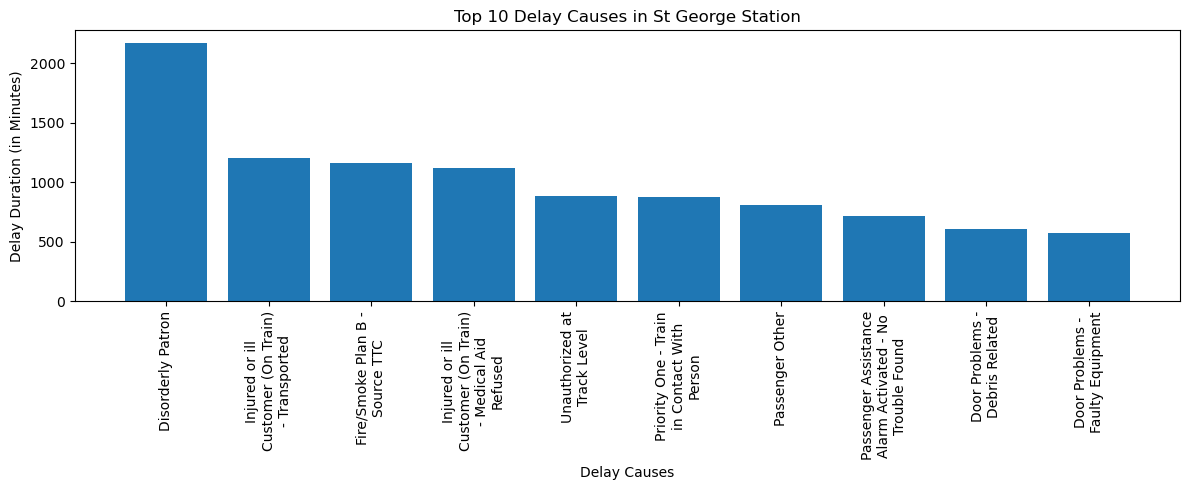

In [62]:
create_bar_chart('St George')

## Eglinton Station

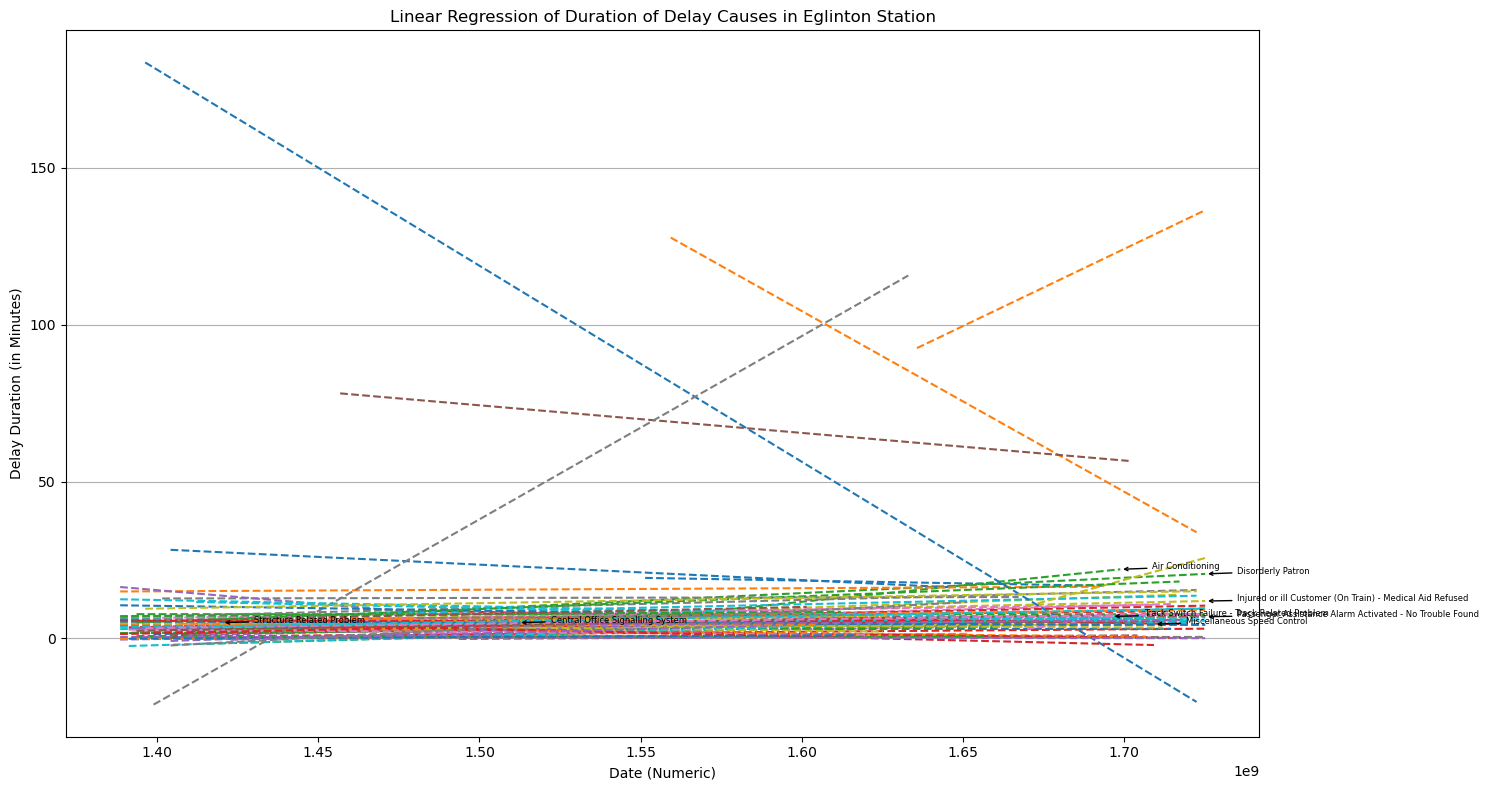

In [63]:
linear_regression_plot('Eglinton')

In [64]:
linear_regression_table('Eglinton')

delay_cause         slope  \
65                          Structure Related Problem  3.145129e-07   
76       Track Switch Failure - Track Related Problem  1.522904e-07   
2                                    Air Conditioning  1.047677e-07   
7                    Central Office Signalling System  9.042245e-08   
12                                  Disorderly Patron  4.885679e-08   
28  Injured or ill Customer (On Train) - Medical A...  2.167388e-08   
43  Passenger Assistance Alarm Activated - No Trou...  1.590398e-08   
34                        Miscellaneous Speed Control  1.537931e-08   

     intercept   r-value   p-value       std_err pval < 0.05 pval < 0.01  
65 -441.630435  1.000000  0.000000  0.000000e+00           Y           Y  
76 -251.302632  1.000000  0.000000  0.000000e+00           Y           Y  
2  -155.979038  1.000000  0.000000  0.000000e+00           Y           Y  
7  -131.726562  1.000000  0.000000  0.000000e+00           Y           Y  
12  -63.746683  0.418633  0.000001  9.635149e-09           Y           Y  
28  -25.499862  0.268806  0.006567  7.805389e-09           Y           Y  
43  -20.554246  0.295582  0.000903  4.672867e-09           Y           Y  
34  -21.747878  0.296106  0.003759  5.172122e-09           Y           Y

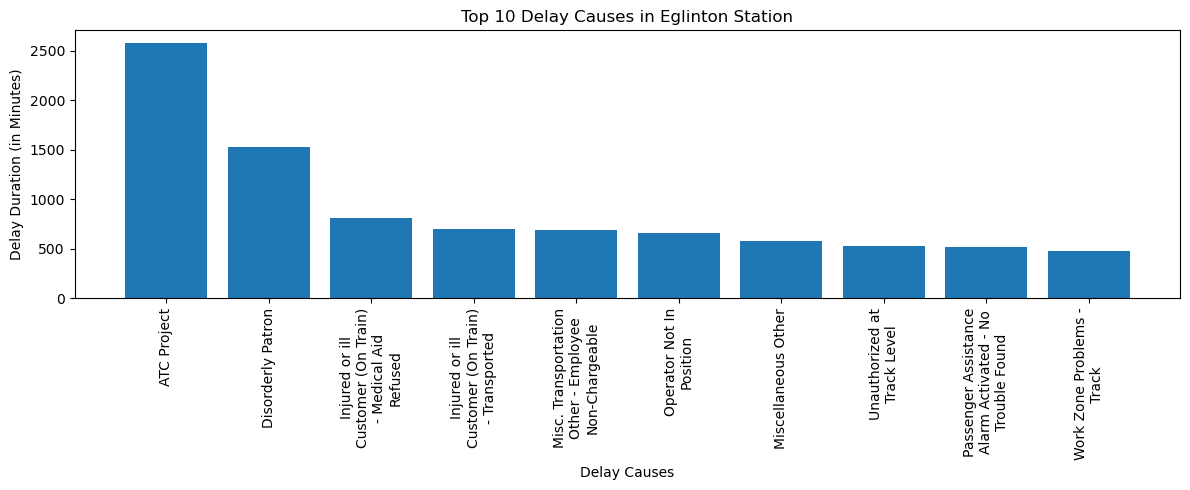

In [65]:
create_bar_chart('Eglinton')

## Finch Station

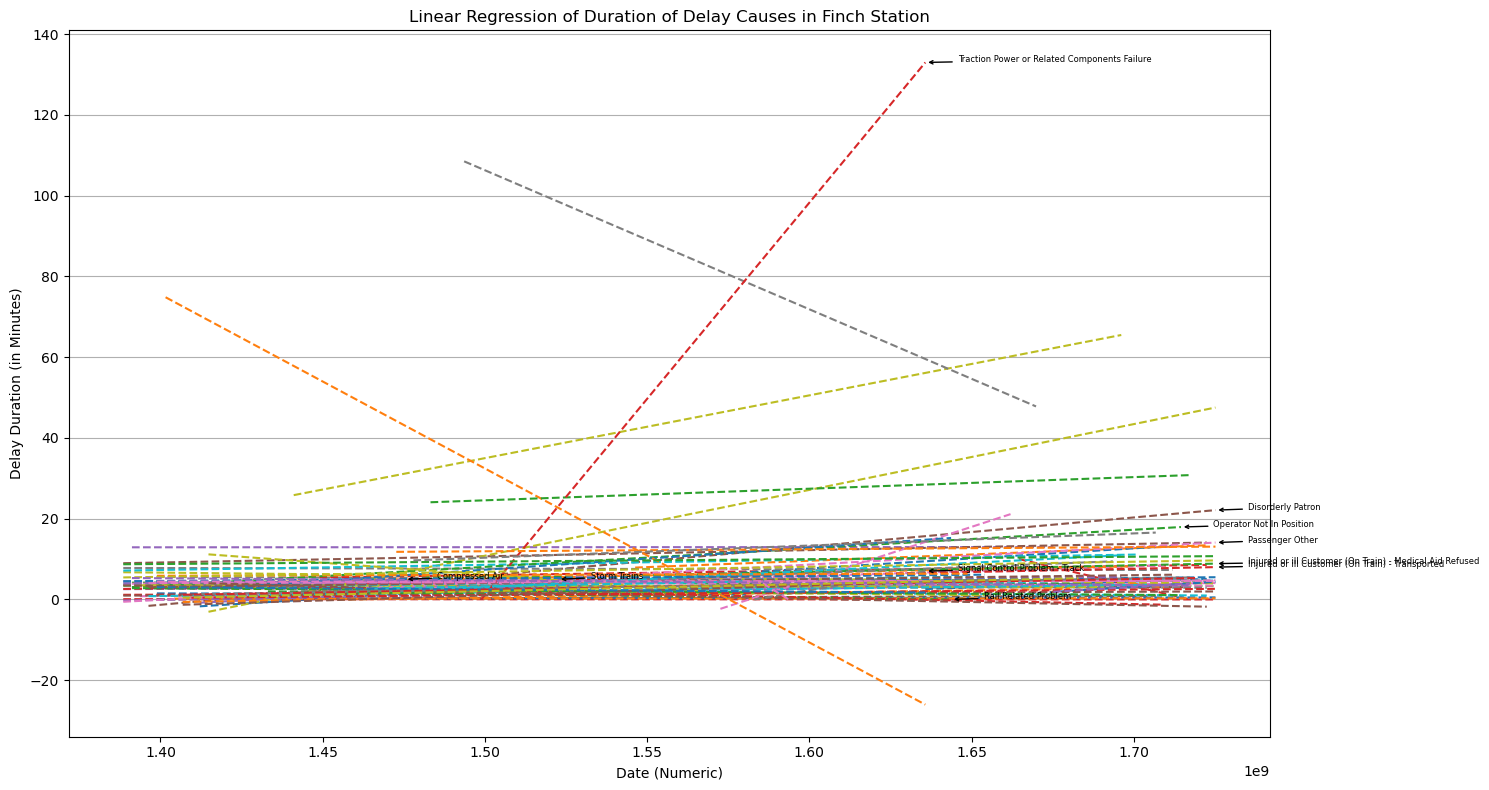

In [66]:
linear_regression_plot('Finch')

In [67]:
linear_regression_table('Finch')

delay_cause         slope  \
73       Traction Power or Related Components Failure  9.718130e-07   
57                     Signal Control Problem - Track  1.328172e-07   
15                                  Disorderly Patron  7.210148e-08   
42                           Operator Not In Position  4.599780e-08   
46                                    Passenger Other  4.357735e-08   
11                                     Compressed Air  1.653439e-08   
32  Injured or ill Customer (On Train) - Medical A...  1.625875e-08   
33   Injured or ill Customer (On Train) - Transported  1.607054e-08   
64                                       Storm Trains  7.462330e-09   
52                               Rail Related Problem -9.498625e-09   

      intercept   r-value   p-value       std_err pval < 0.05 pval < 0.01  
73 -1456.618687  1.000000  0.000000  0.000000e+00           Y           Y  
57  -210.252459  1.000000  0.000000  0.000000e+00           Y           Y  
15  -102.266782  0.447641  0.000001  1.405597e-08           Y           Y  
42   -60.931521  0.355582  0.000674  1.303750e-08           Y           Y  
46   -61.090822  0.358211  0.000952  1.269861e-08           Y           Y  
11   -19.392857  1.000000  0.000000  0.000000e+00           Y           Y  
32   -19.180544  0.312570  0.001634  5.016821e-09           Y           Y  
33   -19.716504  0.354618  0.000453  4.417662e-09           Y           Y  
64    -6.361702  1.000000  0.000000  0.000000e+00           Y           Y  
52    15.612638 -1.000000  0.000000  0.000000e+00           Y           Y

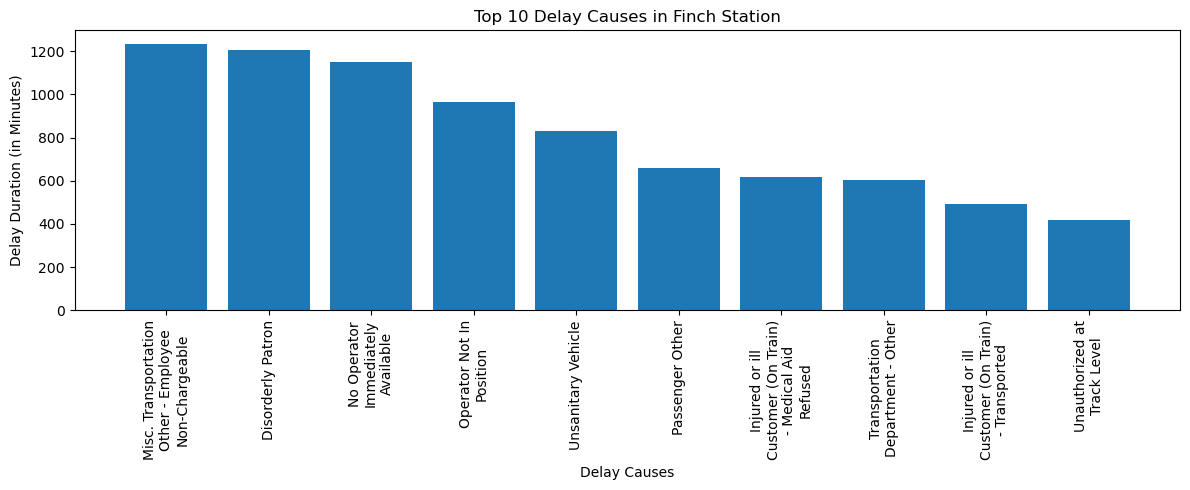

In [68]:
create_bar_chart('Finch')

## Kipling Station

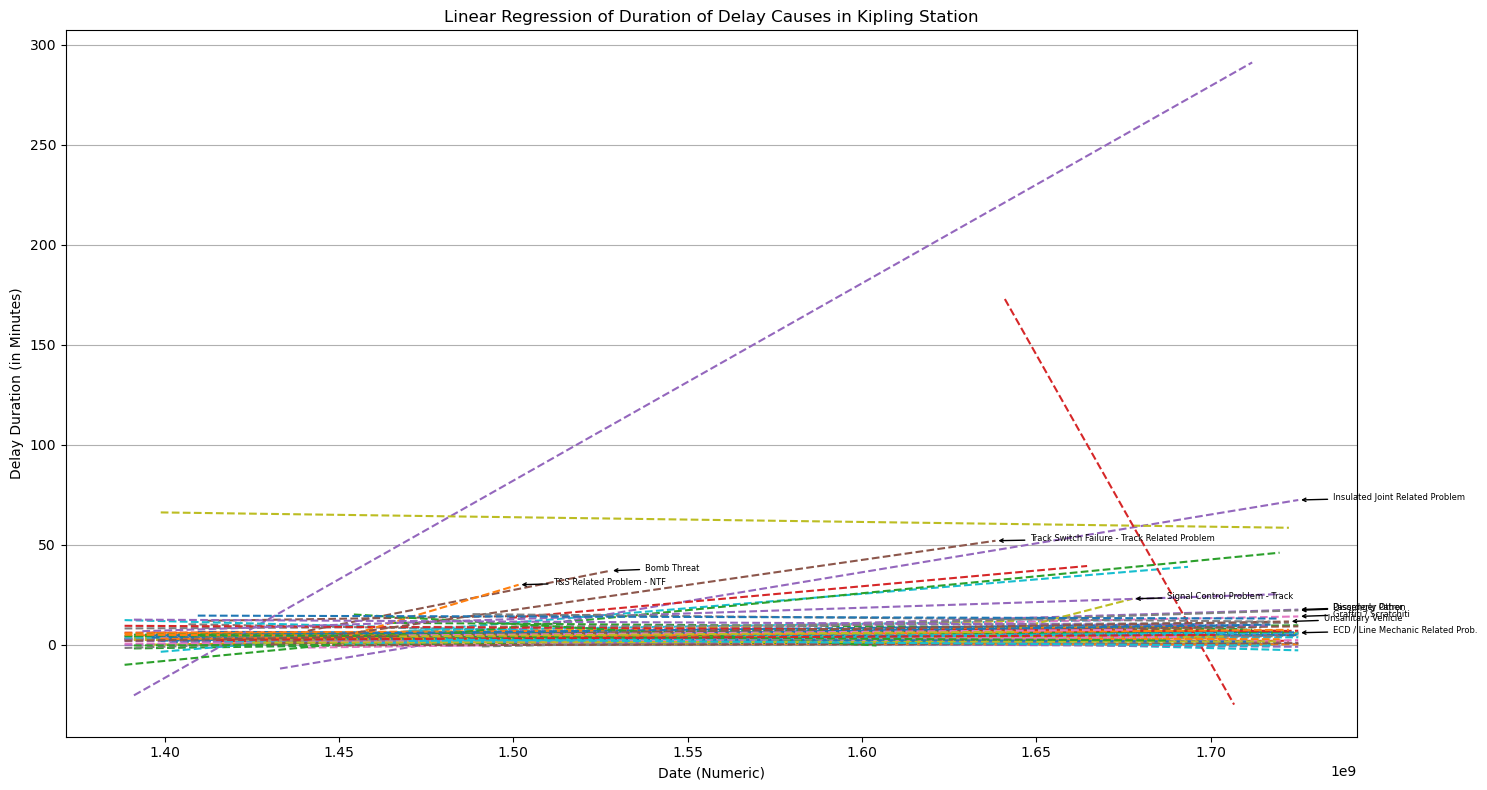

In [69]:
linear_regression_plot('Kipling')

In [70]:
linear_regression_table('Kipling')

delay_cause         slope   intercept  \
71                     T&S Related Problem - NTF  5.206331e-07 -751.754325   
58                Signal Control Problem - Track  4.486075e-07 -729.596899   
5                                    Bomb Threat  3.458389e-07 -491.376494   
34               Insulated Joint Related Problem  2.885267e-07 -425.389473   
75  Track Switch Failure - Track Related Problem  2.501462e-07 -357.818786   
20             ECD / Line Mechanic Related Prob.  1.258052e-07 -211.032609   
47                               Passenger Other  5.590425e-08  -79.213721   
14                             Disorderly Patron  5.271524e-08  -73.361582   
26                         Graffiti / Scratchiti  3.300815e-08  -42.776037   
85                            Unsanitary Vehicle  2.884263e-08  -38.037951   

     r-value       p-value       std_err pval < 0.05 pval < 0.01  
71  1.000000  0.000000e+00  0.000000e+00           Y           Y  
58  1.000000  0.000000e+00  0.000000e+00           Y           Y  
5   1.000000  0.000000e+00  0.000000e+00           Y           Y  
34  0.860127  3.905273e-05  4.745591e-08           Y           Y  
75  1.000000  0.000000e+00  0.000000e+00           Y           Y  
20  1.000000  0.000000e+00  0.000000e+00           Y           Y  
47  0.439949  3.538188e-05  1.275805e-08           Y           Y  
14  0.457382  3.526080e-07  9.728144e-09           Y           Y  
26  0.517392  1.411189e-05  6.990081e-09           Y           Y  
85  0.477143  1.160865e-06  5.538537e-09           Y           Y

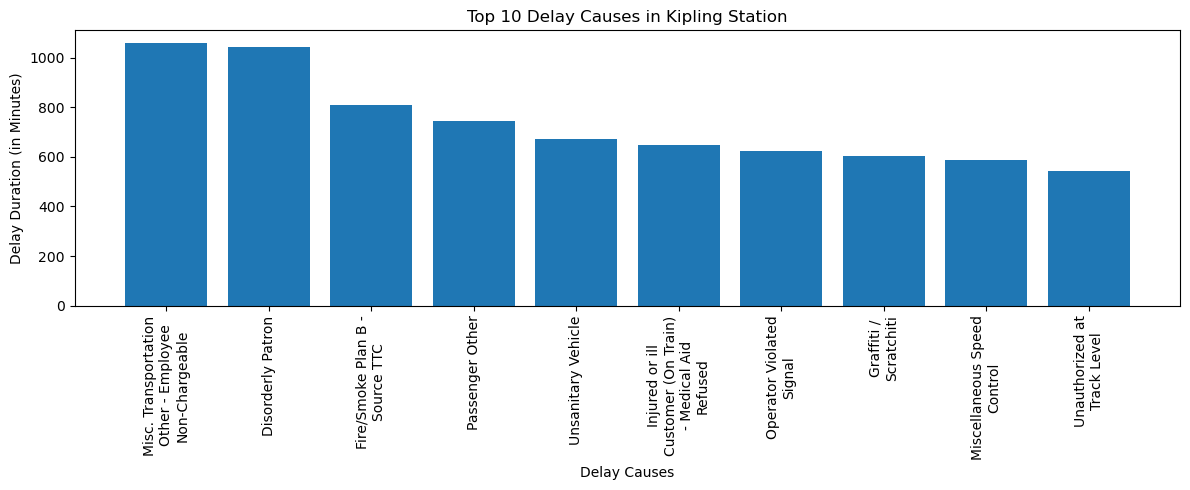

In [71]:
create_bar_chart('Kipling')

## McCowan Station

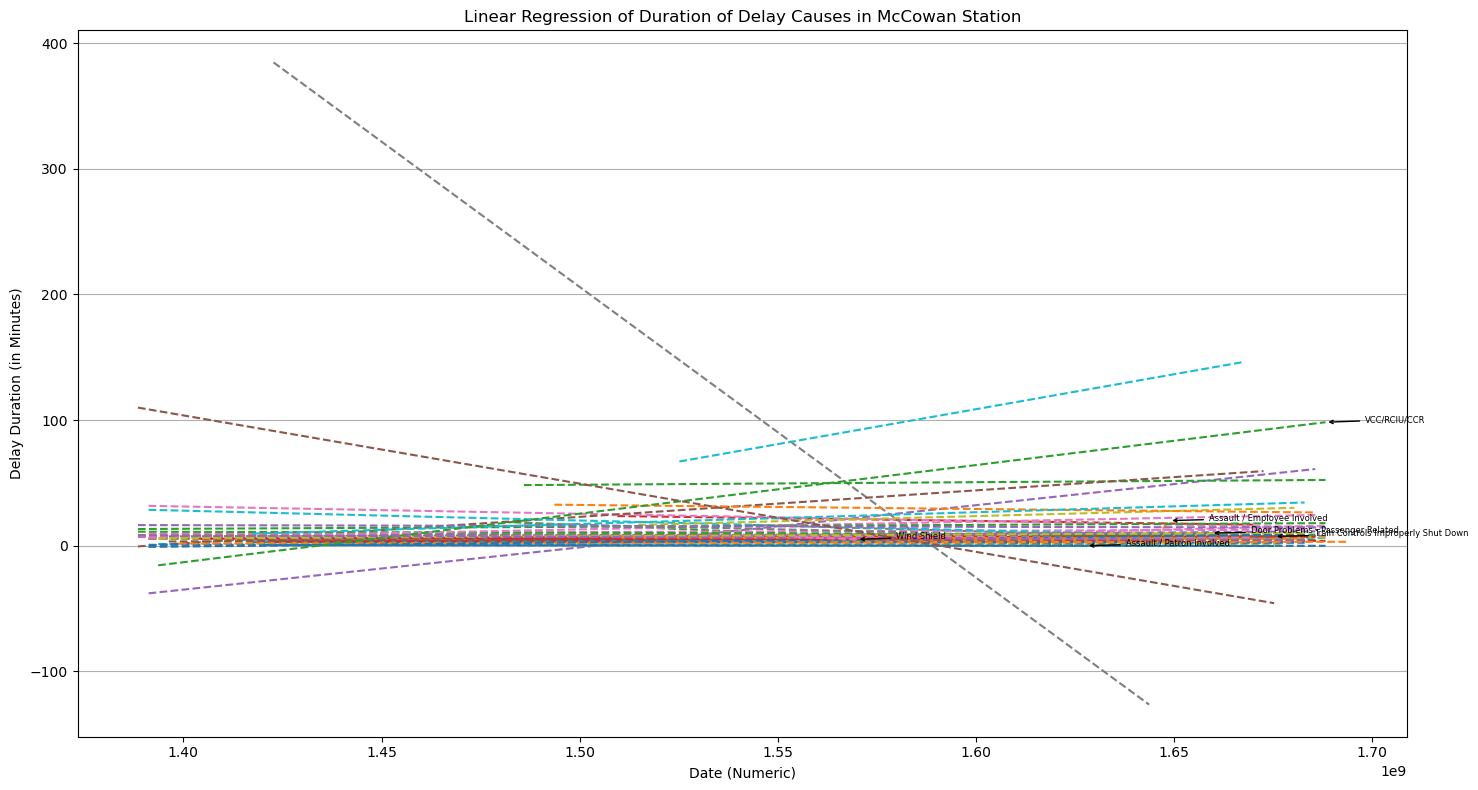

In [72]:
linear_regression_plot('McCowan')

In [73]:
linear_regression_table('McCowan')

delay_cause         slope    intercept   r-value  \
1           Assault / Employee Involved  3.923415e-06 -6448.813559  1.000000   
52                         VCC/RCIU/CCR  3.867000e-07  -554.529316  0.522656   
12    Door Problems - Passenger Related  5.845492e-08   -86.994949  1.000000   
45  Train Controls Improperly Shut Down  1.455915e-08   -16.962012  0.925502   
56                          Wind Shield -1.264926e-07   203.579235 -1.000000   
2             Assault / Patron Involved -1.290536e-07   210.070423 -1.000000   

     p-value       std_err pval < 0.05 pval < 0.01  
1   0.000000  0.000000e+00           Y           Y  
52  0.003046  1.192055e-07           Y           Y  
12  0.000000  0.000000e+00           Y           Y  
45  0.000977  2.432365e-09           Y           Y  
56  0.000000  0.000000e+00           Y           Y  
2   0.000000  0.000000e+00           Y           Y

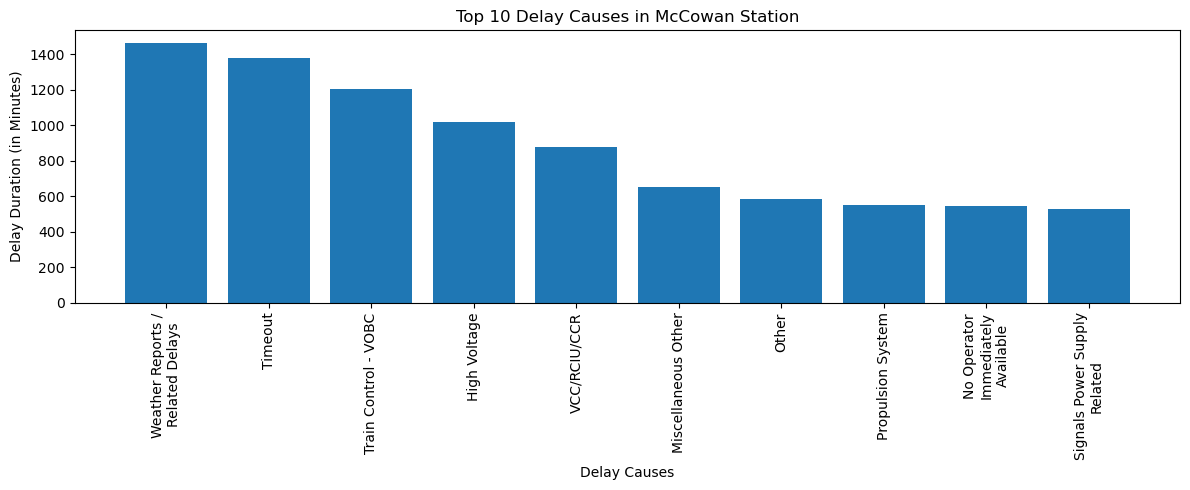

In [74]:
create_bar_chart('McCowan')

## Sheppard West Station

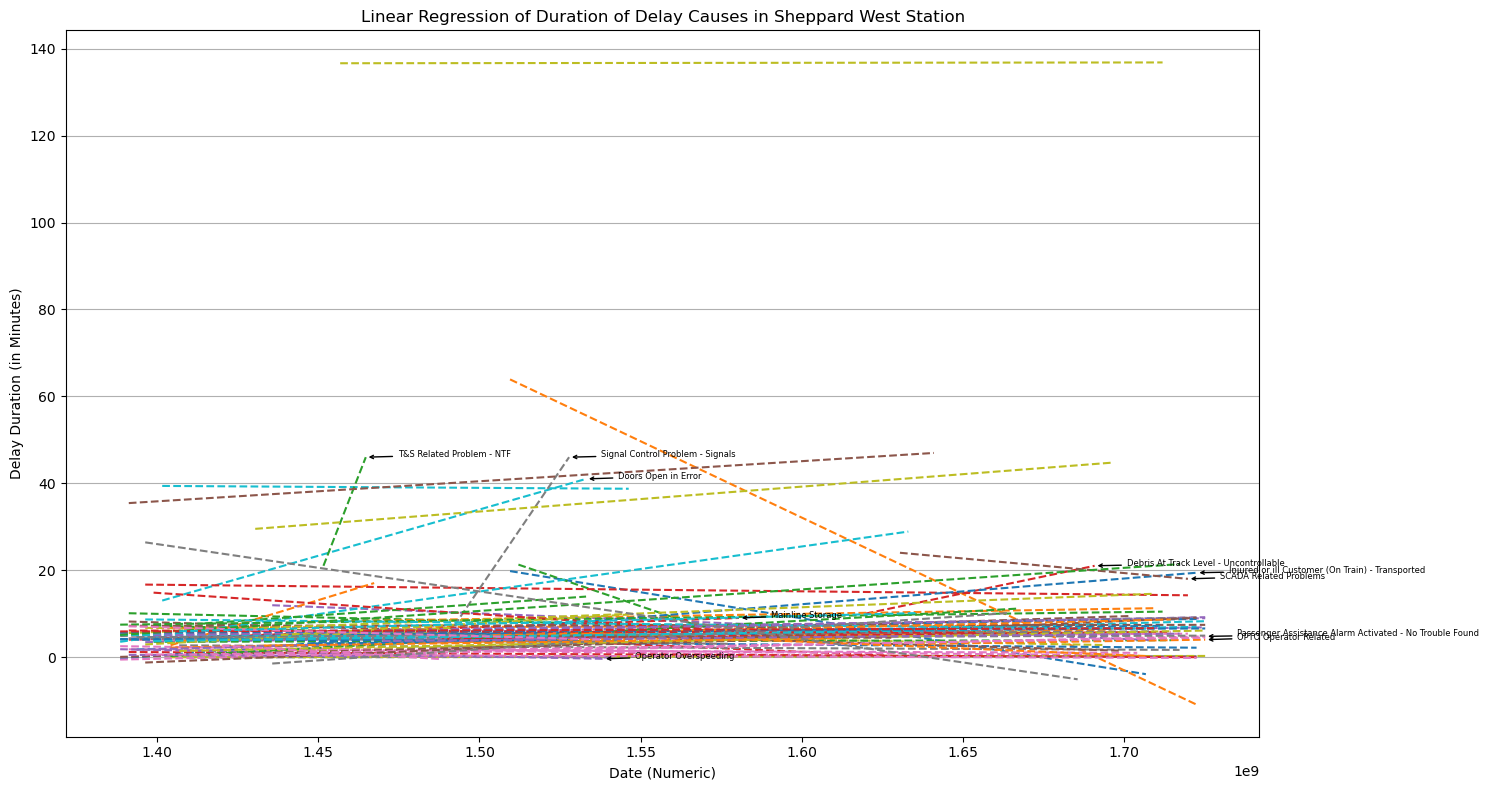

In [75]:
linear_regression_plot('Sheppard West')

In [76]:
linear_regression_table('Sheppard West')

delay_cause         slope  \
72                          T&S Related Problem - NTF  1.903631e-06   
57                   Signal Control Problem - Signals  1.089027e-06   
19                                Doors Open in Error  2.129265e-07   
13             Debris At Track Level - Uncontrollable  1.548842e-07   
30   Injured or ill Customer (On Train) - Transported  5.914853e-08   
33                                   Mainline Storage  2.641277e-08   
46  Passenger Assistance Alarm Activated - No Trou...  1.584931e-08   
41                              OPTO Operator Related  1.118268e-08   
44                              Operator Overspeeding -1.473796e-08   
55                             SCADA Related Problems -6.716097e-08   

      intercept   r-value       p-value       std_err pval < 0.05 pval < 0.01  
72 -2742.322368  1.000000  0.000000e+00  0.000000e+00           Y           Y  
57 -1617.827133  1.000000  0.000000e+00  0.000000e+00           Y           Y  
19  -285.433640  1.000000  0.000000e+00  0.000000e+00           Y           Y  
13  -240.885645  1.000000  0.000000e+00  0.000000e+00           Y           Y  
30   -82.479668  0.542247  1.490689e-06  1.119702e-08           Y           Y  
33   -32.745778  1.000000  0.000000e+00  0.000000e+00           Y           Y  
46   -22.589898  0.544644  1.664664e-08  2.558390e-09           Y           Y  
41   -15.291787  1.000000  0.000000e+00  0.000000e+00           Y           Y  
44    22.265959 -0.442910  6.300242e-04  4.059827e-09           Y           Y  
55   133.502901 -1.000000  0.000000e+00  0.000000e+00           Y           Y

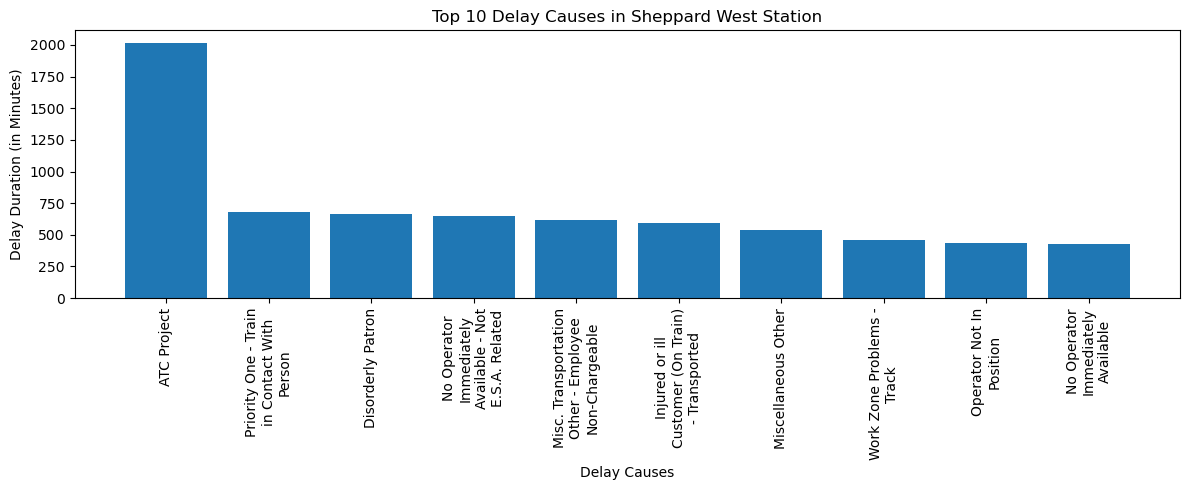

In [77]:
create_bar_chart('Sheppard West')

## Vaughan Metropolitan Centre Station

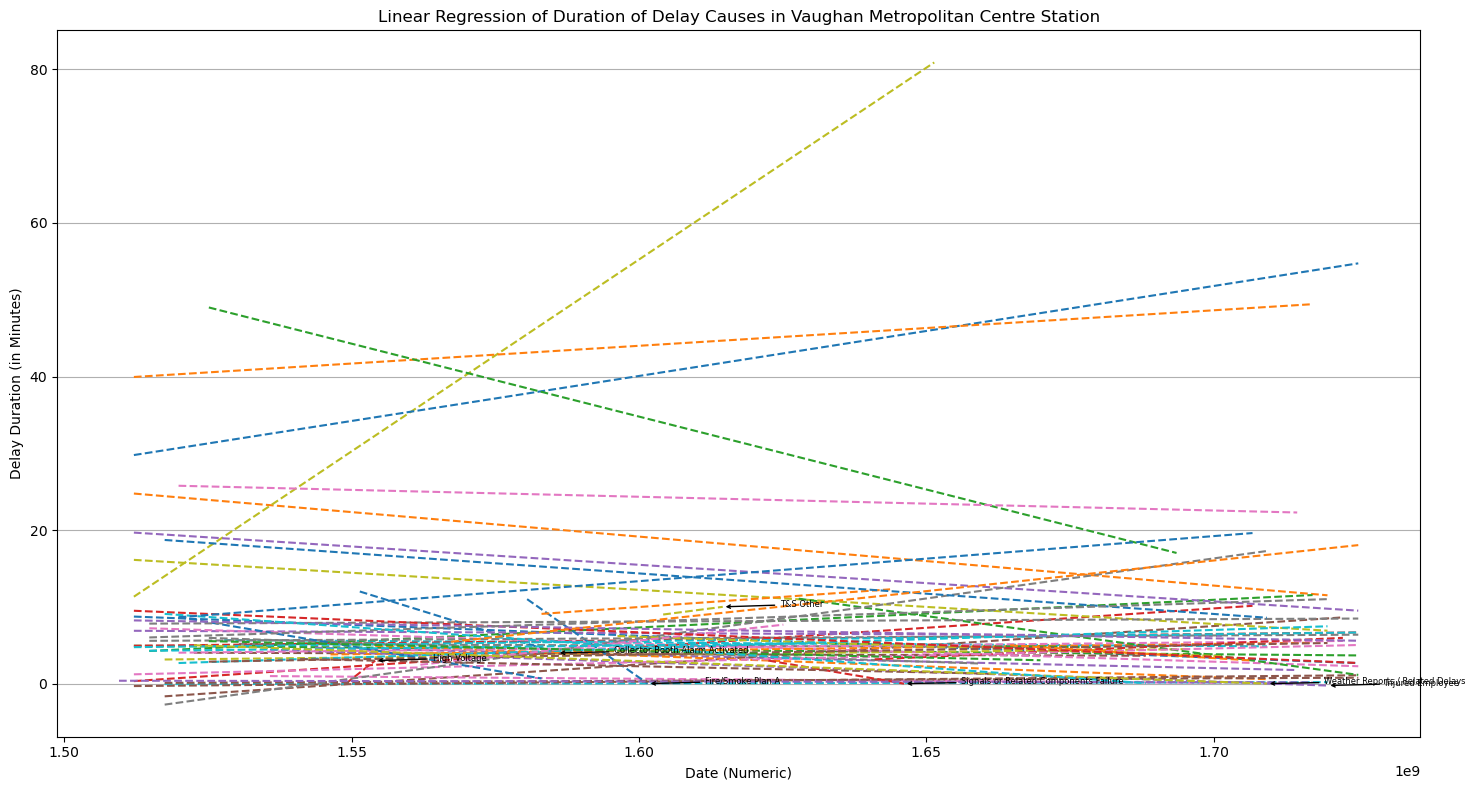

In [78]:
linear_regression_plot('Vaughan Metropolitan Centre')

In [79]:
linear_regression_table('Vaughan Metropolitan Centre')

delay_cause         slope   intercept   r-value  \
23                           High Voltage  5.885122e-07 -911.593220  1.000000   
48                              T&S Other  9.645062e-08 -145.725000  1.000000   
24                       Injured Employee -2.539918e-08   43.429465 -0.564373   
58       Weather Reports / Related Delays -2.677944e-08   45.772790 -1.000000   
43  Signals or Related Components Failure -1.271876e-07  209.362637 -1.000000   
10        Collector Booth Alarm Activated -2.332307e-07  373.833753 -1.000000   
20                      Fire/Smoke Plan A -5.239293e-07  839.078189 -1.000000   

     p-value       std_err pval < 0.05 pval < 0.01  
23  0.000000  0.000000e+00           Y           Y  
48  0.000000  0.000000e+00           Y           Y  
24  0.009535  8.756794e-09           Y           Y  
58  0.000000  0.000000e+00           Y           Y  
43  0.000000  0.000000e+00           Y           Y  
10  0.000000  0.000000e+00           Y           Y  
20  0.000000  0.000000e+00           Y           Y

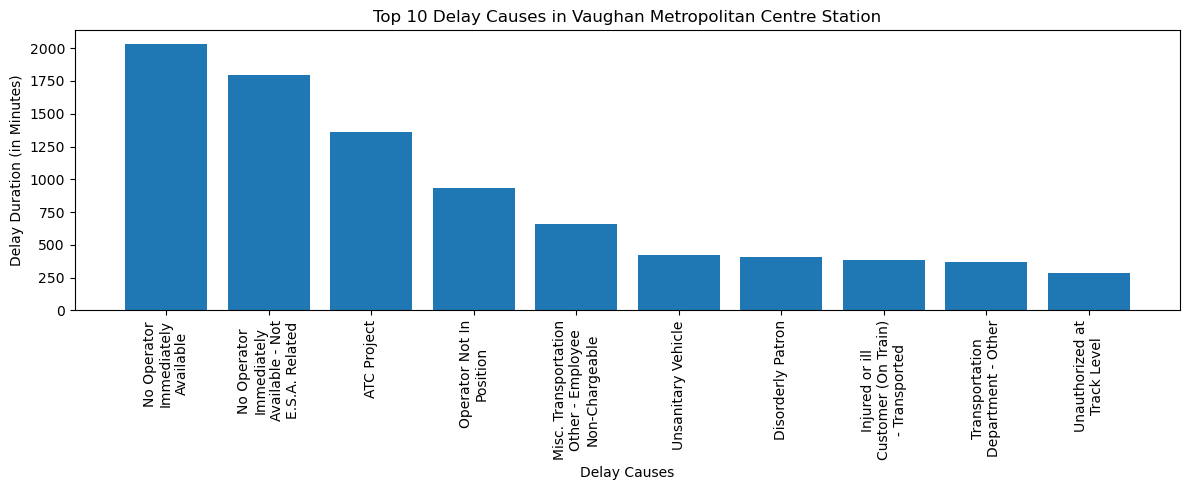

In [80]:
create_bar_chart('Vaughan Metropolitan Centre')